In [7]:
import os
os.chdir(r"Q:/sachuriga/Sachuriga_Python/quattrocolo-nwb4fp/src")

import pandas as pd
from neurochat.nc_data import NData
from neurochat.nc_spike import NSpike
from neurochat.nc_spatial import NSpatial
import neurochat.nc_plot as nc_plot
from neurochat.nc_lfp import NLfp
import matplotlib.pyplot as plt
import numpy as np
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import numpy as np
import math
import pynapple as nap
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

import sys
import nwb4fp.analyses.maps as mapp
from nwb4fp.analyses.examples.tracking_plot import plot_ratemap_ax,plot_path
from nwb4fp.analyses.fields import separate_fields_by_laplace, separate_fields_by_dilation,find_peaks,separate_fields_by_laplace_of_gaussian,calculate_field_centers,distance_to_edge_function, remove_fields_by_area, map_pass_to_unit_circle,which_field,compute_crossings
from elephant.statistics import time_histogram, instantaneous_rate
from nwb4fp.analyses import maps
from nwb4fp.analyses.data import pos2speed,speed_filtered_spikes,load_speed_fromNWB,load_units_fromNWB,get_filed_num,unit_location_ch,calculate_spatial_coherence,calculate_spatial_stability,coherence
from scipy.ndimage import gaussian_filter
import ast
import pandas as pd

In [19]:
import scipy.io
import numpy as np

# Load .mat file
PVcorr_drug = scipy.io.loadmat(r'S:\Sachuriga/PVcorr_drug.mat')
PVcorr_control = scipy.io.loadmat(r'S:\Sachuriga/PVcorr_control.mat')

a = [v for v in PVcorr_drug['PVcorr_drug'][0][0]]
b = [v for v in PVcorr_control['PVcorr_ctrl'][0][0]]

# Remove NaN values from a[0] and b[0]
a_clean = a[0][~np.isnan(a[0])]
b_clean = b[0][~np.isnan(b[0])]

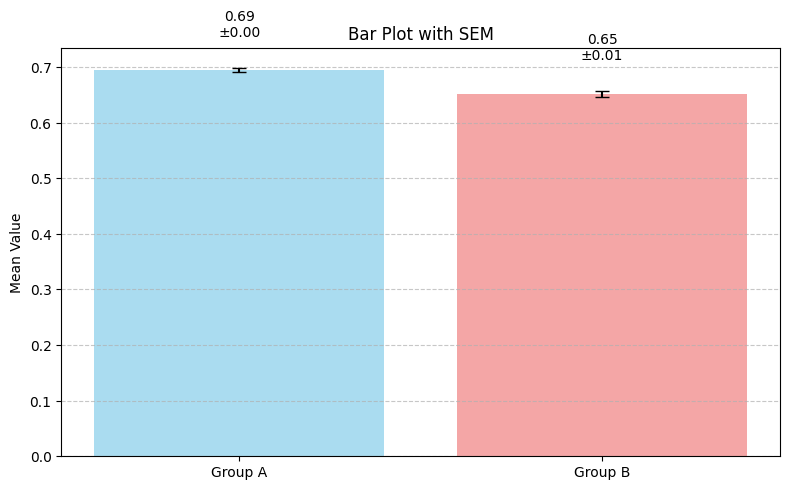

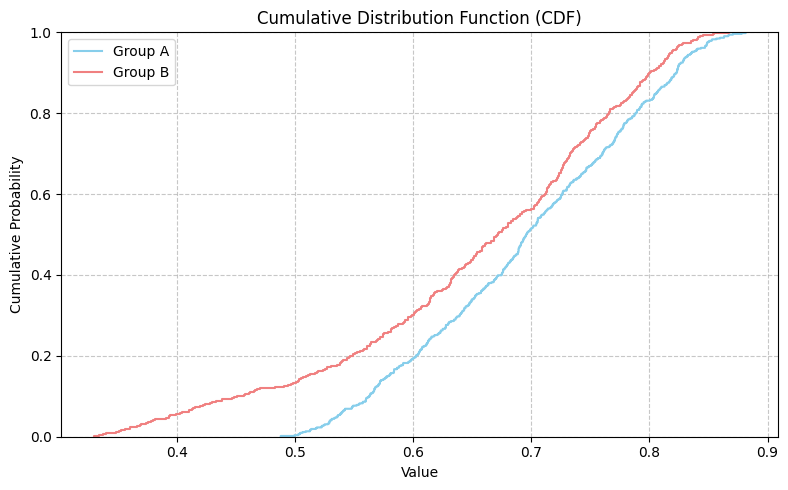

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Perform Mann-Whitney U test
u_stat, p_value_u = stats.mannwhitneyu(a_clean, b_clean, alternative='two-sided')

# Perform KS test
ks_stat, p_value_ks = stats.ks_2samp(a_clean, b_clean)

# 1. Bar Plot with SEM
means = [np.mean(a_clean), np.mean(b_clean)]
sems = [stats.sem(a_clean), stats.sem(b_clean)]  # Standard error of the mean

plt.figure(figsize=(8, 5))
x = ['Group A', 'Group B']
bars = plt.bar(x, means, yerr=sems, capsize=5, color=['skyblue', 'lightcoral'], alpha=0.7)
plt.ylabel('Mean Value')
plt.title('Bar Plot with SEM')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
for bar, mean, sem in zip(bars, means, sems):
    plt.text(bar.get_x() + bar.get_width()/2, mean + sem + 0.05, 
             f'{mean:.2f}\n±{sem:.2f}', ha='center', va='bottom')
plt.tight_layout()

# 2. Cumulative Distribution Plot (CDF)
plt.figure(figsize=(8, 5))
sns.ecdfplot(data=a_clean, label='Group A', color='skyblue')
sns.ecdfplot(data=b_clean, label='Group B', color='lightcoral')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# 3. Histogram
plt.figure(figsize=(8, 5))
plt.hist(a_clean, bins=10, alpha=0.5, label='Group A', color='skyblue', density=True)
plt.hist(b_clean, bins=10, alpha=0.5, label='Group B', color='lightcoral', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [22]:
p_value_ks

6.541740312476933e-05

In [15]:
import numpy as np
import pandas as pd

def population_vector_correlation(stack1, stack2, full='off', orientation='v'):
    """
    Calculates correlation between population vectors.
    Parameters:
    -----------
    stack1 : ndarray
        3D matrix (neurons, x_bins, y_bins) - population vector
    stack2 : ndarray
        3D matrix (neurons, x_bins, y_bins) - population vector
    full : str, optional
        'off': returns diagonal elements (2D matrix)
        'on': returns full correlation matrices (3D matrix)
        'vector': returns correlations as a vector (1D array)
        Default is 'vector'
    orientation : str, optional
        'v': vertical (rows/x-axis), 'h': horizontal (columns/y-axis)
        Only used when full='vector'. Default is 'v'
    
    Returns:
    --------
    pv_corr : ndarray or None
        Correlation values (1D, 2D, or 3D depending on 'full'), or None if insufficient neurons
    """
    
    # Validate inputs and check neuron count
    if stack1.ndim != 3 or stack2.ndim != 3:
        raise ValueError("Input stacks must be 3D arrays")
    
    num_cells1 = stack1.shape[0]
    num_cells2 = stack2.shape[0]
    
    if num_cells1 < 5 or num_cells2 < 5:
        return None
    
    # Get dimensions
    num_cells = min(num_cells1, num_cells2)
    num_x_bins = min(stack1.shape[1], stack2.shape[1])
    num_y_bins = min(stack1.shape[2], stack2.shape[2])
    
    if num_cells1 != num_cells2:
        print(f"Warning: Population vectors have different neuron counts: {num_cells1} vs {num_cells2}")
    
    # Truncate stacks to minimum dimensions
    stack1 = stack1[:num_cells, :num_x_bins, :num_y_bins]
    stack2 = stack2[:num_cells, :num_x_bins, :num_y_bins]
    
    # Initialize output based on return format
    if full == 'vector':
        num_bins = num_x_bins if orientation == 'v' else num_y_bins
        pv_corr = np.zeros(num_bins)
    elif full == 'off':
        pv_corr = np.zeros((num_x_bins, num_y_bins))
    elif full == 'on':
        pv_corr = np.zeros((num_x_bins, num_y_bins, num_cells))
    else:
        raise ValueError("full must be 'off', 'on', or 'vector'")
    
    # Process based on orientation and return format
    if full == 'vector':
        if orientation == 'v':
            for i in range(num_x_bins):
                vec1 = stack1[:, i, :].reshape(-1)
                vec2 = stack2[:, i, :].reshape(-1)
                pv_corr[i] = np.corrcoef(vec1, vec2)[0, 1]
        else:  # 'h'
            for i in range(num_y_bins):
                vec1 = stack1[:, :, i].reshape(-1)
                vec2 = stack2[:, :, i].reshape(-1)
                pv_corr[i] = np.corrcoef(vec1, vec2)[0, 1]
    
    else:  # full = 'off' or 'on'
        for i in range(num_x_bins):
            for j in range(num_y_bins):
                vec1 = stack1[:, i, j]
                vec2 = stack2[:, i, j]
                corr_matrix = np.corrcoef(vec1, vec2)
                if full == 'off':
                    pv_corr[i, j] = corr_matrix[0, 1]
                else:  # 'on'
                    pv_corr[i, j, :] = corr_matrix[0, :]
    
    # Replace NaN values with 0
    pv_corr = np.nan_to_num(pv_corr, nan=0)
    
    return pv_corr

# Define control and experimental animal IDs
control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']

# Initialize dictionaries to store PVs for

In [25]:
import pandas as pd
import numpy as np

def process_dataframe(df, normalize=True):
    # Drop rows where ratemaps is NaN/None
    df = df.dropna(subset=['rate_maps'])
    
    # Define control and experimental groups
    control_ids = ['65165', '65091', '63383', '66539', '65622']
    exp_ids = ['65588', '63385', '66538', '66537', '66922']
    # Create new dataframe to store results
    result_df = pd.DataFrame()
    
    # Process each row
    for index, row in df.iterrows():
        animal_id = row['animal_id']
        ratemaps = row['rate_maps']
        
        # Determine group
        if animal_id in control_ids:
            group = 'control'
        elif animal_id in exp_ids:
            group = 'exp'
        
        # Create new row dictionary
        new_row = {'animal_id': animal_id, 'group': group}
        # Handle different ratemaps lengths and optionally normalize
        if len(ratemaps) == 3:
            # Process each map with optional normalization
            if normalize:
                new_row['A'] = ratemaps[0] / np.nanmean(ratemaps[0]) if np.nanmean(ratemaps[0]) != 0 else ratemaps[0]
                new_row['B'] = ratemaps[1] / np.nanmean(ratemaps[1]) if np.nanmean(ratemaps[1]) != 0 else ratemaps[1]
                new_row['C'] = ratemaps[2] / np.nanmean(ratemaps[2]) if np.nanmean(ratemaps[2]) != 0 else ratemaps[2]
            else:
                new_row['A'] = ratemaps[0]
                new_row['B'] = ratemaps[1]
                new_row['C'] = ratemaps[2]
            
        elif len(ratemaps) == 2:
            # Process maps with optional normalization
            if normalize:
                map1 = ratemaps[0] / np.nanmean(ratemaps[0]) if np.nanmean(ratemaps[0]) != 0 else ratemaps[0]
                map2 = ratemaps[1] / np.nanmean(ratemaps[1]) if np.nanmean(ratemaps[1]) != 0 else ratemaps[1]
            else:
                map1 = ratemaps[0]
                map2 = ratemaps[1]

            # Assign maps based on session info
            if 'Session1' in row and 'Session2' in row:
                if row['Session1'] == 1.0:
                    new_row['A'] = map1
                    if row['Session2'] == 2.0:
                        new_row['B'] = map2
                    elif row['Session2'] == 3.0:
                        new_row['C'] = map2
                
                elif row['Session1'] == 2.0:
                    new_row['B'] = map1
                    new_row['C'] = map2
        
        # Add row to result dataframe
        result_df = pd.concat([result_df, pd.DataFrame([new_row])], ignore_index=True)
    return result_df

# # Example usage:
# pairs_df=pd.read_pickle(r"Q:\sachuriga\CR_CA1_paper\tables/Remapping_ratemaps_unsmoothed.pkl")
# # Assuming your data is loaded in pairs_df
# pairs_df = pairs_df[(pairs_df['cell_type1']=="pyramidal") 
#               & (pairs_df['cell_type2']=="pyramidal")]
# Process with normalization (default)
processed_df_normalized = process_dataframe(pairs_df, normalize=True)
print("Normalized DataFrame:")
print(processed_df_normalized.head())

# Process without normalization
processed_df_unnormalized = process_dataframe(pairs_df, normalize=False)
print("\nUnnormalized DataFrame:")
print(processed_df_unnormalized.head())

Normalized DataFrame:
  animal_id    group                                                  A  \
0     65165  control  [[0.0, 8.091566104150809e-17, 0.0, 7.371772038...   
1     65165  control  [[0.0, 0.0, 2.003528369346961e-16, 0.0, 0.0, 0...   
2     65165  control  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.889162346653...   
3     65091  control  [[7.023426521802276e-07, 3.951027469400643e-06...   
4     65091  control  [[7.023426521802276e-07, 3.951027469400643e-06...   

                                                   B  \
0  [[0.18486671409088717, 0.14626628009717393, 0....   
1  [[0.0672055215160826, 0.04380098587514585, 0.0...   
2                                                NaN   
3  [[0.0021545990677594427, 0.011820233602615537,...   
4  [[0.0021545990677594427, 0.011820233602615537,...   

                                                   C  
0  [[0.0, 0.0, 3.167591924765941e-05, 0.001379287...  
1                                                NaN  
2  [[0.0, 0.0, 0.0, 0.0, 

In [24]:
pairs_df=pd.read_pickle(r"Q:\sachuriga\CR_CA1_paper\tables/Remapping_ratemaps_unsmoothed.pkl")
# Assuming your data is loaded in pairs_df
pairs_df = pairs_df[(pairs_df['cell_type1']=="pyramidal") 
              & (pairs_df['cell_type2']=="pyramidal")]
pairs_df = pairs_df[(pairs_df['functional cell type1']!="place cell") 
              & (pairs_df['functional cell type2']!="place cell")]

Statistical Tests for A and B:
  Mann-Whitney U Test (original data):
    U Statistic: 66947.0000
    P-value: 0.0001
  KS 2-Sample Test (pseudo data):
    KS Statistic: 0.2225
    P-value: 0.0000

Statistical Tests for B and C:
  Mann-Whitney U Test (original data):
    U Statistic: 103021.0000
    P-value: 0.0000
  KS 2-Sample Test (pseudo data):
    KS Statistic: 0.2725
    P-value: 0.0000

Statistical Tests for A and C:
  Mann-Whitney U Test (original data):
    U Statistic: 120102.0000
    P-value: 0.0000
  KS 2-Sample Test (pseudo data):
    KS Statistic: 0.3950
    P-value: 0.0000



C:\Users\sachur\AppData\Local\Temp\ipykernel_18144\3441789901.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


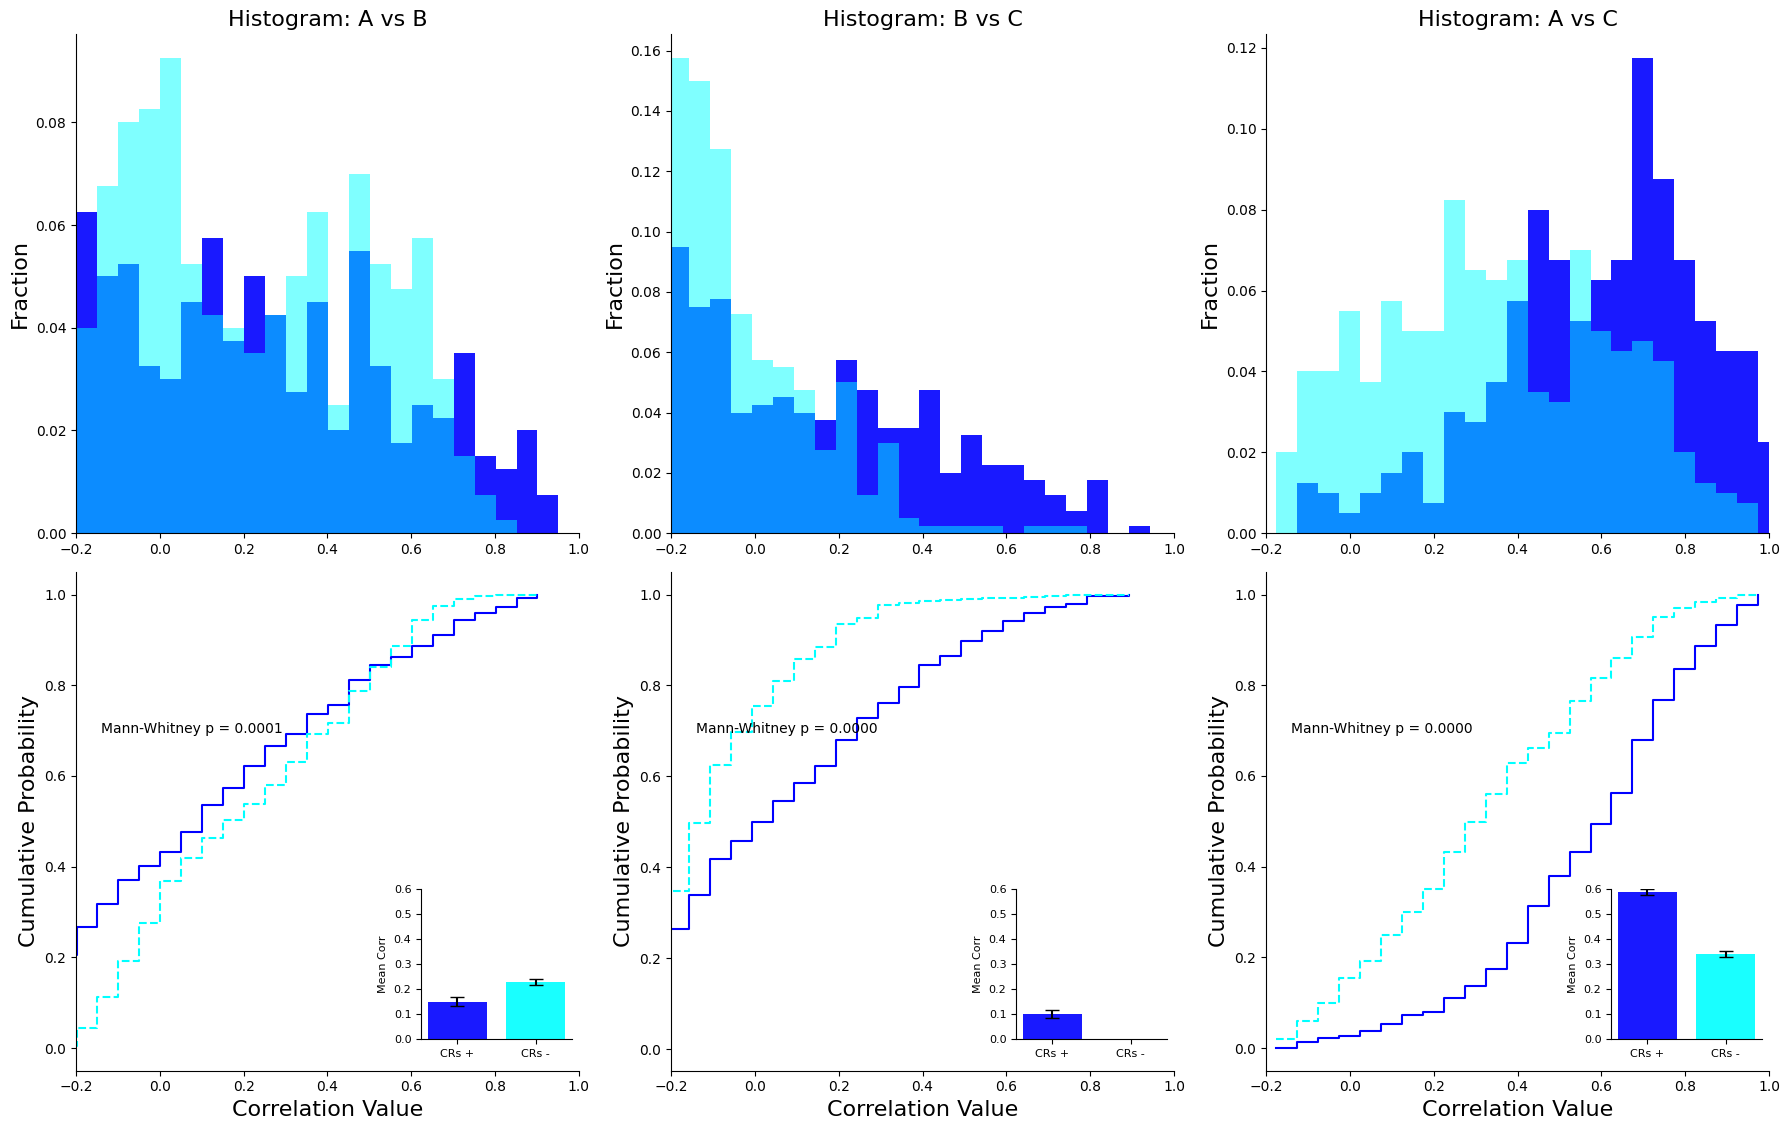

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assume processed_df_normalized and population_vector_correlation are defined
patterns = [("A", "B"), ("B", "C"), ("A", "C")]

# Set up figure with subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12), height_ratios=[1, 1])

for idx, (s1, s2) in enumerate(patterns):
    # Filter rows where both s1 and s2 have values (not null)
    filtered_df = processed_df_normalized.dropna(subset=[s1, s2])
    control_df = filtered_df[filtered_df['group'] == 'control']
    exp_df = filtered_df[filtered_df['group'] == 'exp']

    def to_3d_array(df, column, i=2, j=2):
        values = df[column].values
        n = len(values)
        return np.array([np.full((i, j), val) for val in values])

    i, j = 20, 20
    control_a_3d = to_3d_array(control_df, s1, i, j)
    control_b_3d = to_3d_array(control_df, s2, i, j)
    exp_a_3d = to_3d_array(exp_df, s1, i, j)
    exp_b_3d = to_3d_array(exp_df, s2, i, j)
    control_corr = population_vector_correlation(control_a_3d, control_b_3d, full='off')
    exp_corr = population_vector_correlation(exp_a_3d, exp_b_3d, full='off')

    if control_corr is None or exp_corr is None:
        print(f"Not enough neurons (<5) to compute correlations for {s1} and {s2}. Adjust your data.")
        continue

    control_corr_flat = control_corr.flatten()
    exp_corr_flat = exp_corr.flatten()

    bin_size = 0.05
    bins = np.arange(min(control_corr_flat.min(), exp_corr_flat.min()), 
                     max(control_corr_flat.max(), exp_corr_flat.max()) + bin_size, 
                     bin_size)

    # Compute histograms (counts, not density)
    control_hist, control_bin_edges = np.histogram(control_corr_flat, bins=bins)
    exp_hist, exp_bin_edges = np.histogram(exp_corr_flat, bins=bins)
    
    # Calculate fractions
    control_frac = control_hist / control_hist.sum()
    exp_frac = exp_hist / exp_hist.sum()

    # Calculate bin centers
    control_bin_centers = (control_bin_edges[:-1] + control_bin_edges[1:]) / 2
    exp_bin_centers = (exp_bin_edges[:-1] + exp_bin_edges[1:]) / 2

    # Create pseudo-datasets by multiplying bin counts with bin centers
    control_pseudo = []
    exp_pseudo = []
    
    for count, center in zip(control_hist, control_bin_centers):
        control_pseudo.extend([center] * int(count))
    
    for count, center in zip(exp_hist, exp_bin_centers):
        exp_pseudo.extend([center] * int(count))

    # Convert to numpy arrays
    control_pseudo = np.array(control_pseudo)
    exp_pseudo = np.array(exp_pseudo)

    # Compute CDFs for plotting (using original data)
    control_hist_density, _ = np.histogram(control_corr_flat, bins=bins, density=True)
    exp_hist_density, _ = np.histogram(exp_corr_flat, bins=bins, density=True)
    control_cdf = np.cumsum(control_hist_density) / np.sum(control_hist_density)
    exp_cdf = np.cumsum(exp_hist_density) / np.sum(exp_hist_density)

    # Plot histograms with fractions
    axes[0, idx].bar(control_bin_centers, control_frac, width=bin_size, alpha=0.9, label='Control', color='blue', align='center')
    axes[0, idx].bar(exp_bin_centers, exp_frac, width=bin_size, alpha=0.5, label='Exp', color='cyan', align='center')
    axes[0, idx].set_title(f'Histogram: {s1} vs {s2}', fontsize=16)
    axes[0, idx].set_ylabel('Fraction', fontsize=16)
    axes[0, idx].legend().set_visible(False)
    axes[0, idx].spines['top'].set_visible(False)
    axes[0, idx].spines['right'].set_visible(False)
    axes[0, idx].set_aspect('auto')
    axes[0, idx].set_xlim([-0.2, 1])

    # Plot CDFs
    axes[1, idx].plot(control_bin_edges[:-1], control_cdf, label=f'Control ({s1}, {s2})', 
                      color='blue', linestyle='-', drawstyle='steps-post')
    axes[1, idx].plot(exp_bin_edges[:-1], exp_cdf, label=f'Exp ({s1}, {s2})', 
                      color='cyan', linestyle='--', drawstyle='steps-post')
    axes[1, idx].set_xlabel('Correlation Value', fontsize=16)
    axes[1, idx].set_ylabel('Cumulative Probability', fontsize=16)
    axes[1, idx].legend().set_visible(False)
    axes[1, idx].spines['top'].set_visible(False)
    axes[1, idx].spines['right'].set_visible(False)
    axes[1, idx].set_aspect('auto')
    axes[1, idx].set_xlim([-0.2, 1])

    # Calculate means and SEM
    control_mean = np.mean(control_corr_flat)
    exp_mean = np.mean(exp_corr_flat)
    control_sem = stats.sem(control_corr_flat)
    exp_sem = stats.sem(exp_corr_flat)

    # Create inset axes for bar plot in top-right corner
    inset_ax = inset_axes(axes[1, idx], width="100%", height="100%", loc='lower right',
                     bbox_to_anchor=(0.7, 0.05, 0.3, 0.3),  # 4-tuple: x0, y0, width, height
                     bbox_transform=axes[1, idx].transAxes)
    
    inset_ax.bar([0.2, 0.8], [control_mean, exp_mean], yerr=[control_sem, exp_sem], 
                 color=['blue', 'cyan'], alpha=0.9, width=0.45, capsize=5)
    inset_ax.set_xticks([0.2, 0.8])
    inset_ax.set_xticklabels(['CRs +', 'CRs -'], fontsize=8)
    inset_ax.set_ylabel('Mean Corr', fontsize=8)
    inset_ax.tick_params(axis='both', labelsize=8)
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)
    inset_ax.set_ylim([0, 0.6])

    # Statistical tests
    u_stat, p_value_u = stats.mannwhitneyu(control_corr_flat, exp_corr_flat, alternative='two-sided')
    ks_stat, p_value_ks = stats.ks_2samp(control_pseudo, exp_pseudo)

    # Add Mann-Whitney p-value to CDF plot
    axes[1, idx].text(0.05, 0.7, f'Mann-Whitney p = {p_value_u:.4f}', transform=axes[1, idx].transAxes, 
                      fontsize=10, verticalalignment='top')

    print(f"Statistical Tests for {s1} and {s2}:")
    print(f"  Mann-Whitney U Test (original data):")
    print(f"    U Statistic: {u_stat:.4f}")
    print(f"    P-value: {p_value_u:.4f}")
    print(f"  KS 2-Sample Test (pseudo data):")
    print(f"    KS Statistic: {ks_stat:.4f}")
    print(f"    P-value: {p_value_ks:.4f}")
    print()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Assuming processed_df is already defined
# Filter rows where both "A" and "B" have values (not null)
filtered_df = processed_df.dropna(subset=['A', 'B', 'C'])
control_df = filtered_df[filtered_df['group'] == 'control']
exp_df = filtered_df[filtered_df['group'] == 'exp']

# Function to create 3D array from a column
def to_3d_array(df, column, i=2, j=2):
    values = df[column].values
    n = len(values)
    return np.array([np.full((i, j), val) for val in values])

# Dimensions
i, j = 20, 20

# Create 3D arrays for all columns (control and exp)
control_a_3d = to_3d_array(control_df, 'A', i, j)
control_b_3d = to_3d_array(control_df, 'B', i, j)
control_c_3d = to_3d_array(control_df, 'C', i, j)
exp_a_3d = to_3d_array(exp_df, 'A', i, j)
exp_b_3d = to_3d_array(exp_df, 'B', i, j)
exp_c_3d = to_3d_array(exp_df, 'C', i, j)

# Compute correlations for all three patterns
patterns = [
    ('A vs B', control_a_3d, control_b_3d, exp_a_3d, exp_b_3d),
    ('A vs C', control_a_3d, control_c_3d, exp_a_3d, exp_c_3d),
    ('B vs C', control_b_3d, control_c_3d, exp_b_3d, exp_c_3d)
]

# Store results
correlations = {}
cdfs = {}

for pattern_name, ctrl_x, ctrl_y, exp_x, exp_y in patterns:
    # Compute correlations
    control_corr = population_vector_correlation(ctrl_x, ctrl_y, full='off')
    exp_corr = population_vector_correlation(exp_x, exp_y, full='off')
    
    if control_corr is None or exp_corr is None:
        print(f"Not enough neurons (<5) to compute correlations for {pattern_name}. Adjust your data.")
        continue
    
    # Flatten correlation matrices
    control_flat = control_corr.flatten()
    exp_flat = exp_corr.flatten()
    
    # Store correlations
    correlations[pattern_name] = (control_flat, exp_flat)
    
    # Compute CDFs
    control_sorted = np.sort(control_flat)
    control_cdf = np.arange(1, len(control_sorted) + 1) / len(control_sorted)
    exp_sorted = np.sort(exp_flat)
    exp_cdf = np.arange(1, len(exp_sorted) + 1) / len(exp_sorted)
    
    cdfs[pattern_name] = (control_sorted, control_cdf, exp_sorted, exp_cdf)

# Plotting and KS tests
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
colors = {'Control': 'blue', 'Exp': 'cyan'}

for idx, (pattern_name, (ctrl_sorted, ctrl_cdf, exp_sorted, exp_cdf)) in enumerate(cdfs.items()):
    ax = axes[idx]
    ax.plot(ctrl_sorted, ctrl_cdf, color='blue', label='Control')
    ax.plot(exp_sorted, exp_cdf, color='cyan', label='Exp')
    ax.set_title(f'CDF: {pattern_name}')
    ax.set_xlabel('Correlation Value')
    ax.set_ylabel('Cumulative Probability' if idx == 0 else '')
    ax.legend()
    ax.grid(True)
    
    # Perform KS test
    ks_stat, p_value = ks_2samp(correlations[pattern_name][0], correlations[pattern_name][1])
    print(f"{pattern_name} KS Test: statistic={ks_stat:.4f}, p-value={p_value:.4f}")

plt.tight_layout()
plt.show()

NameError: name 'processed_df' is not defined

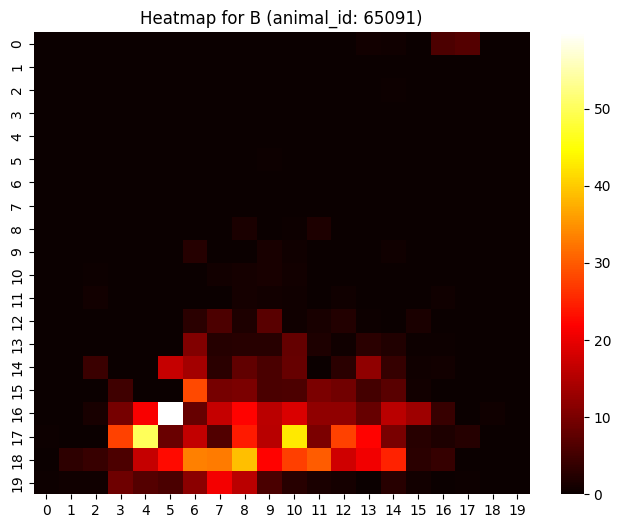

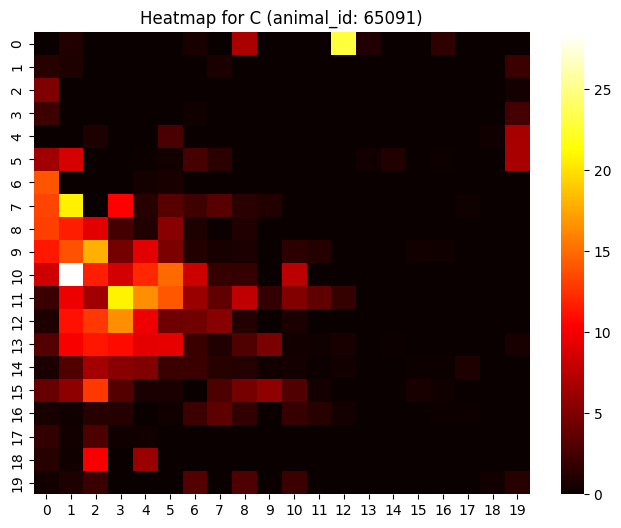

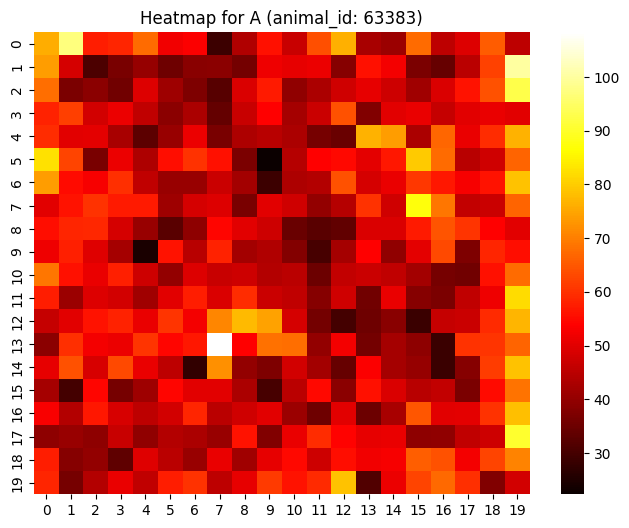

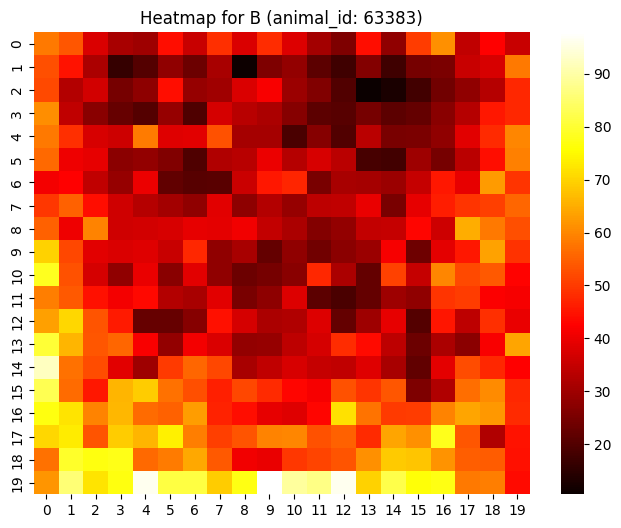

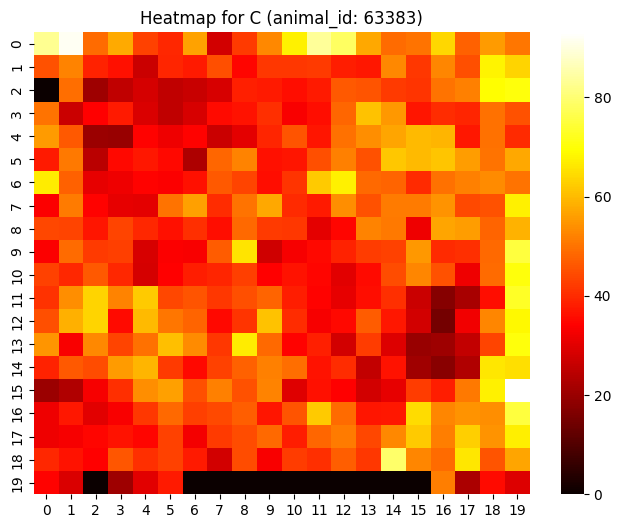

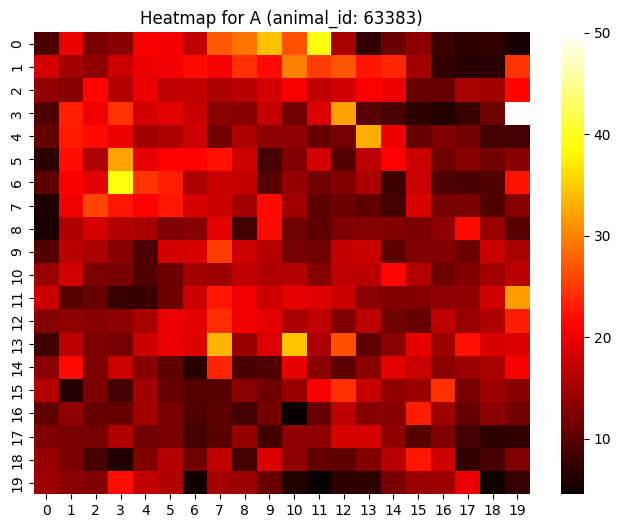

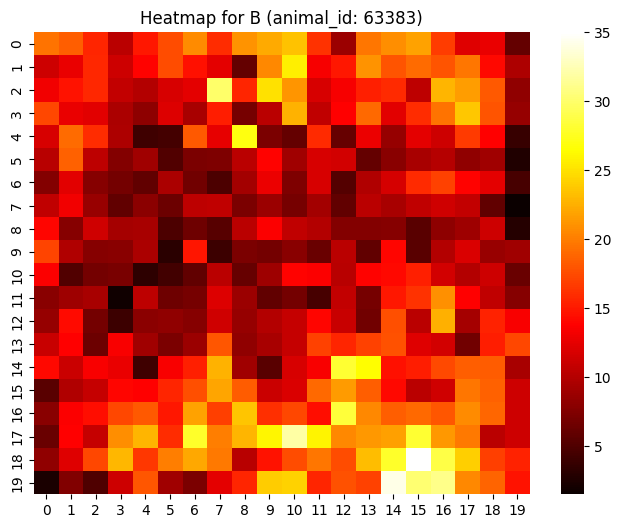

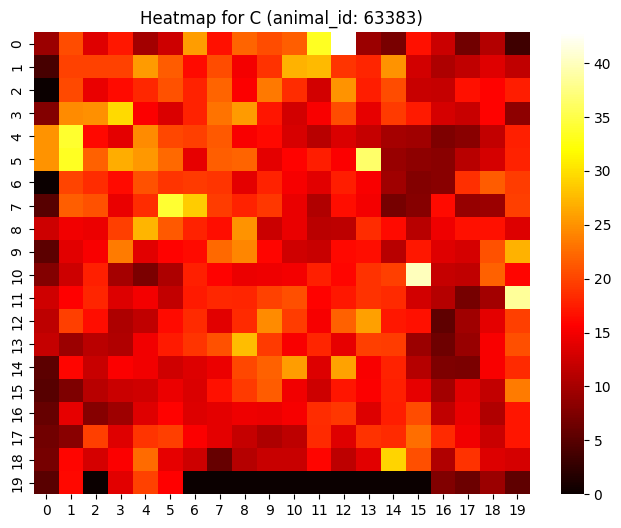

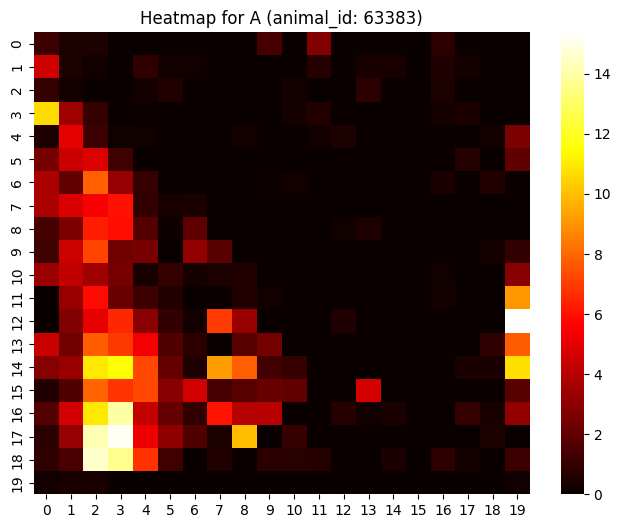

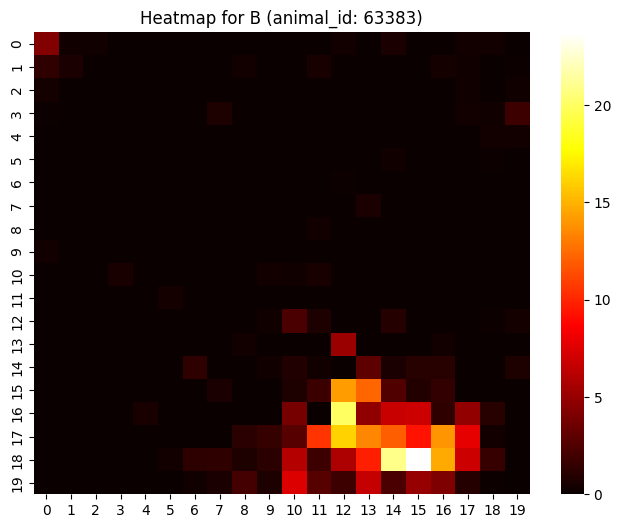

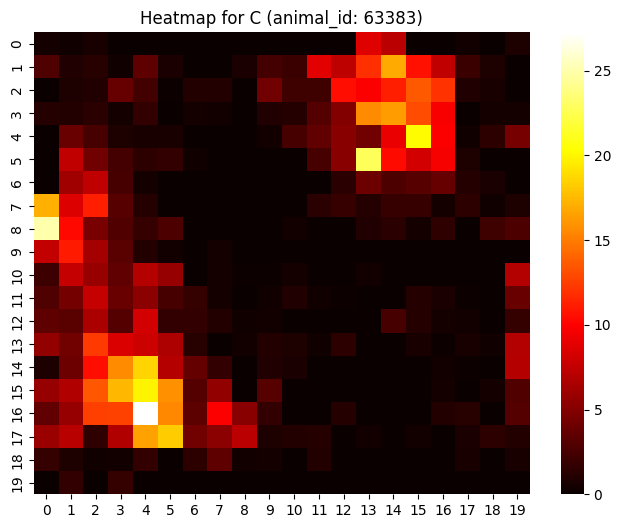

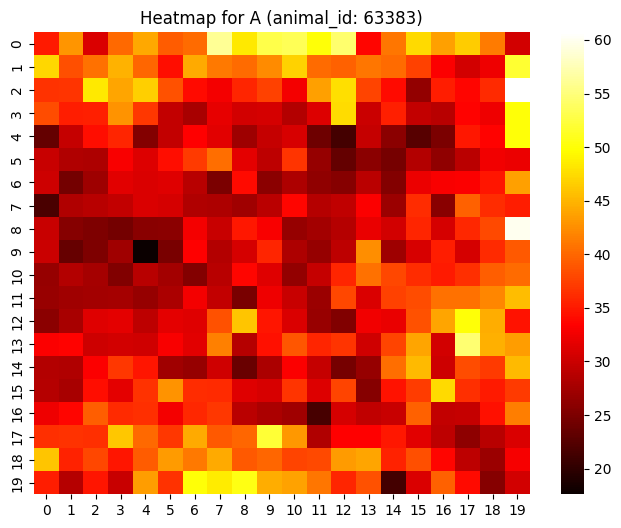

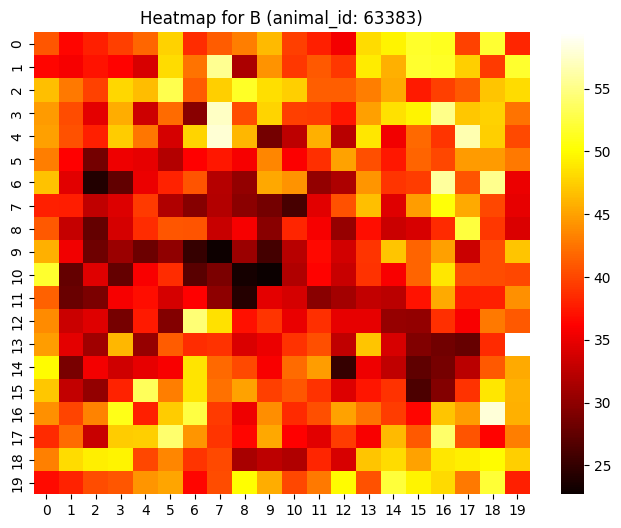

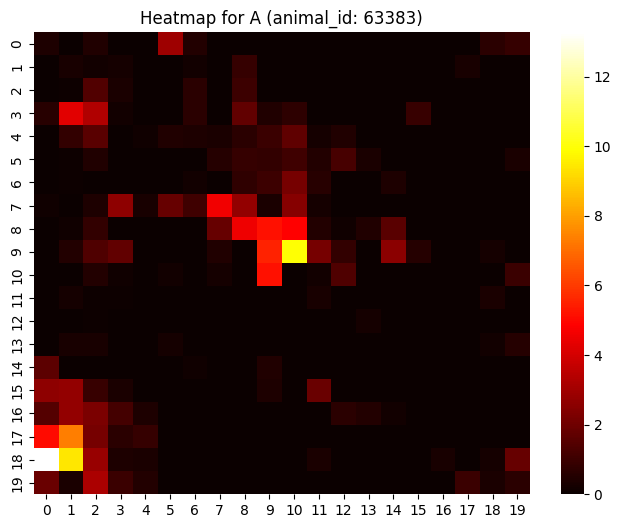

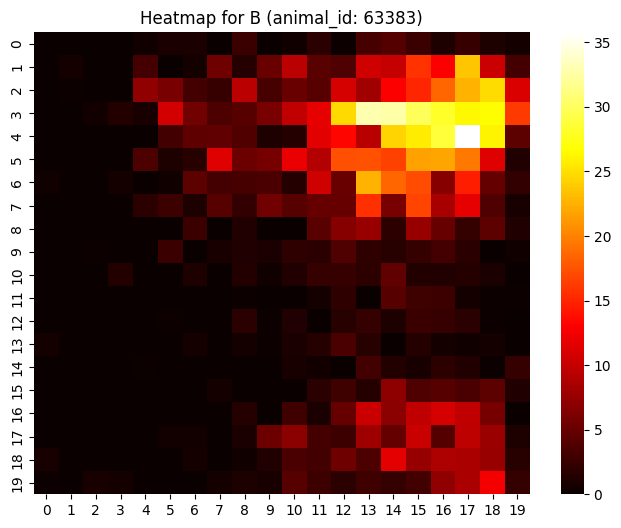

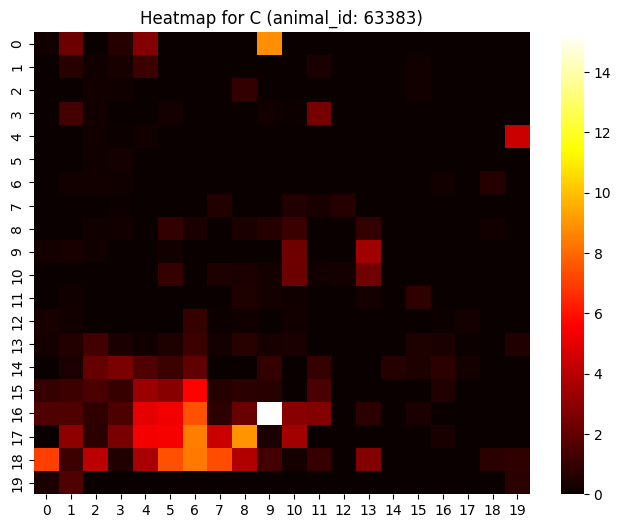

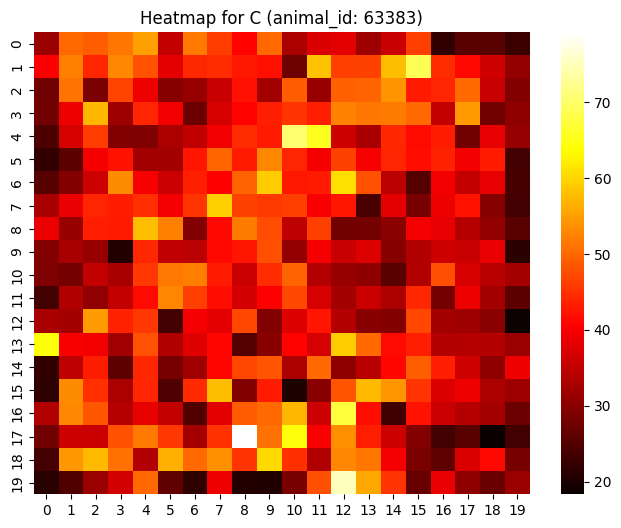

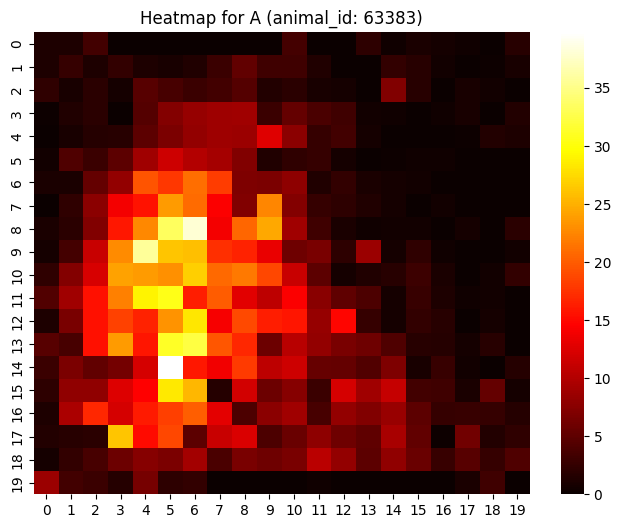

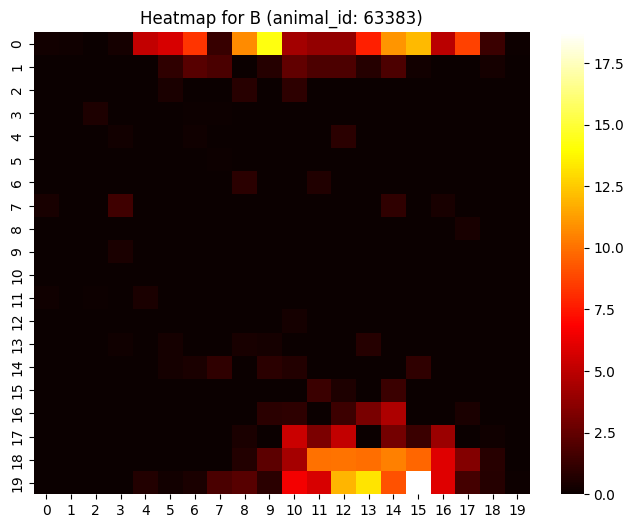

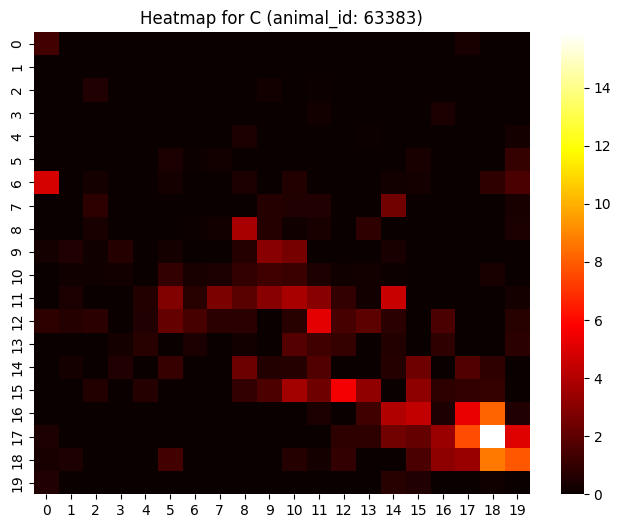

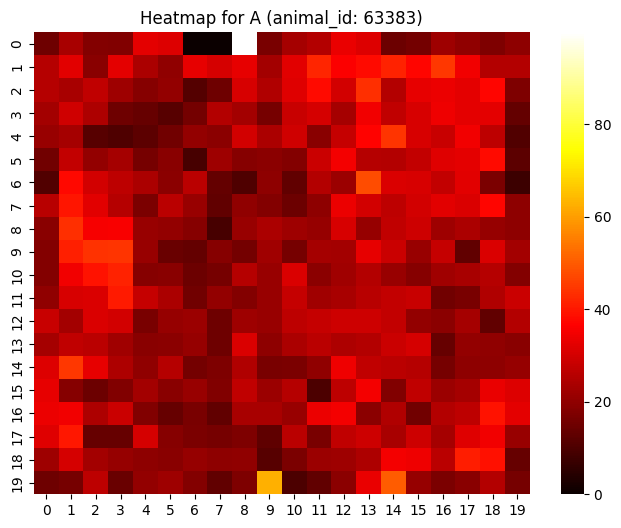

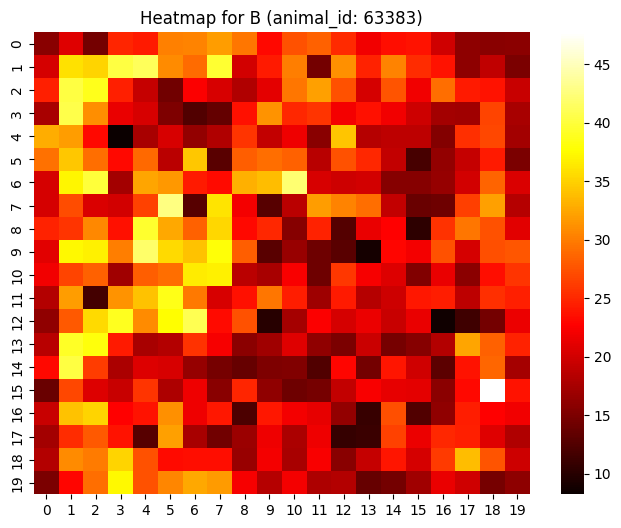

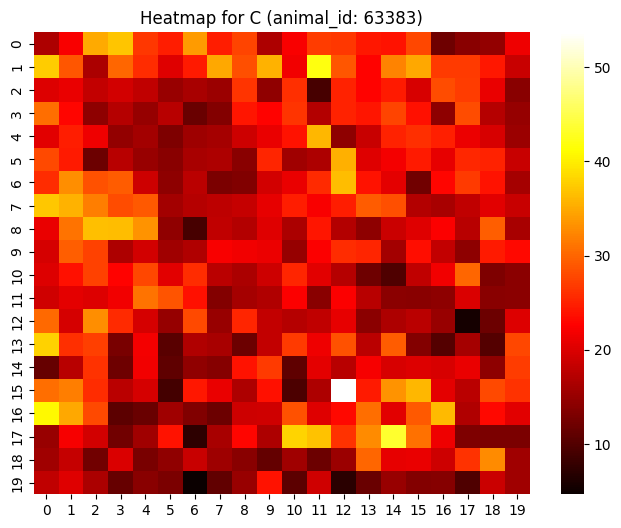

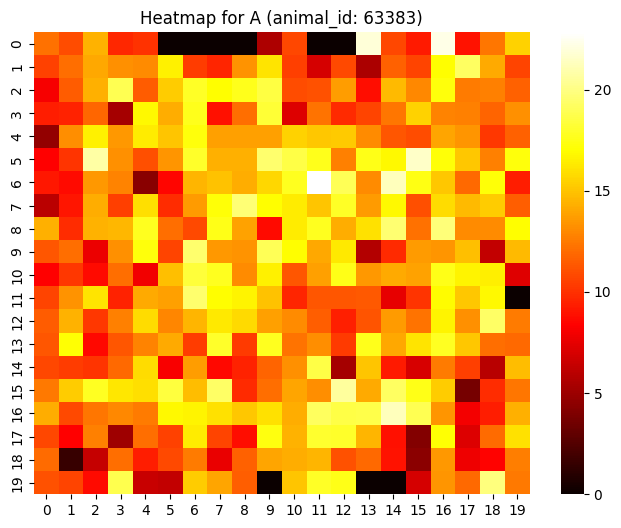

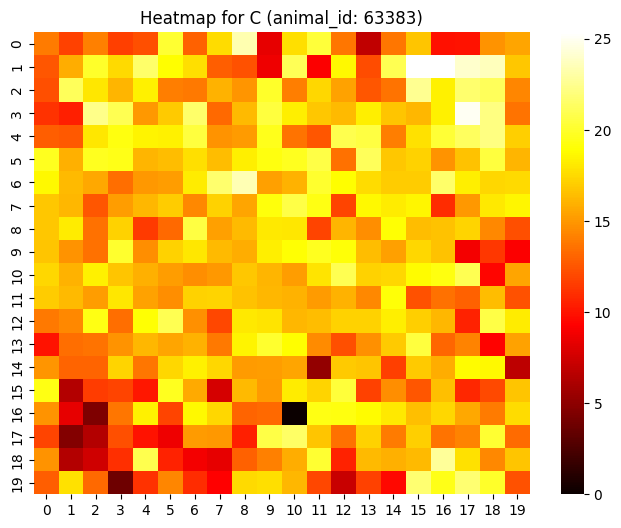

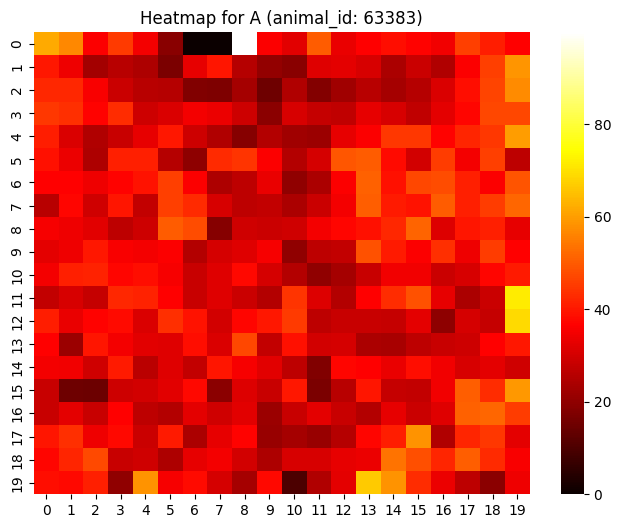

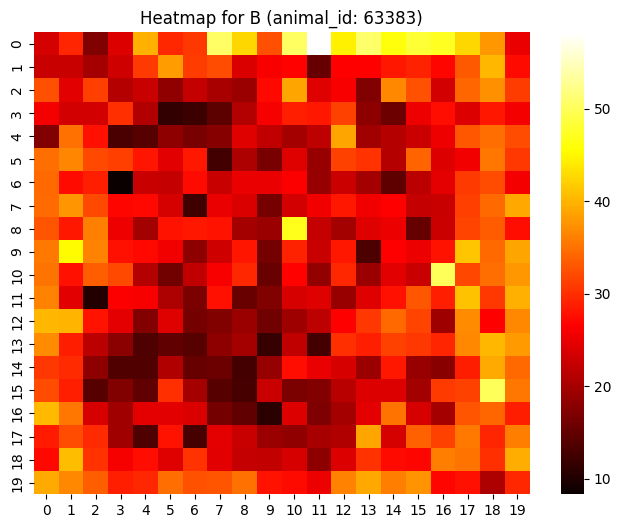

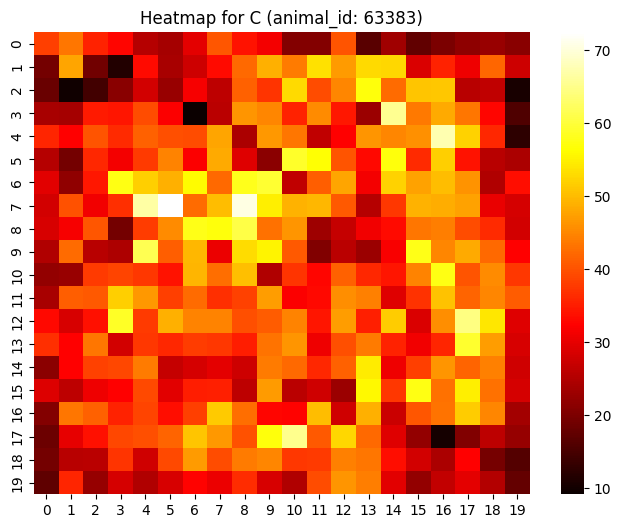

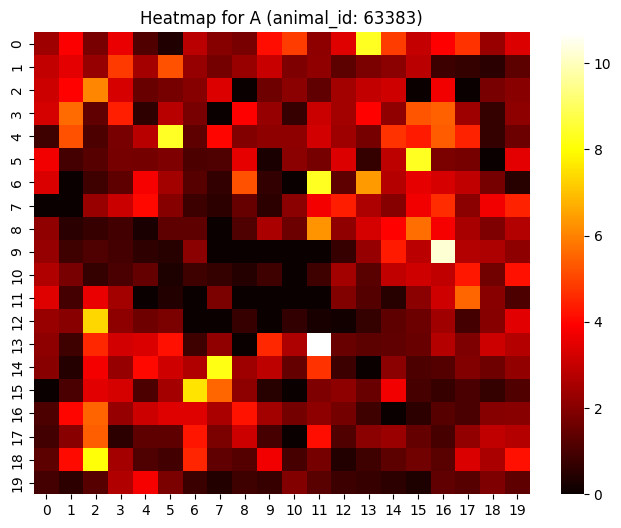

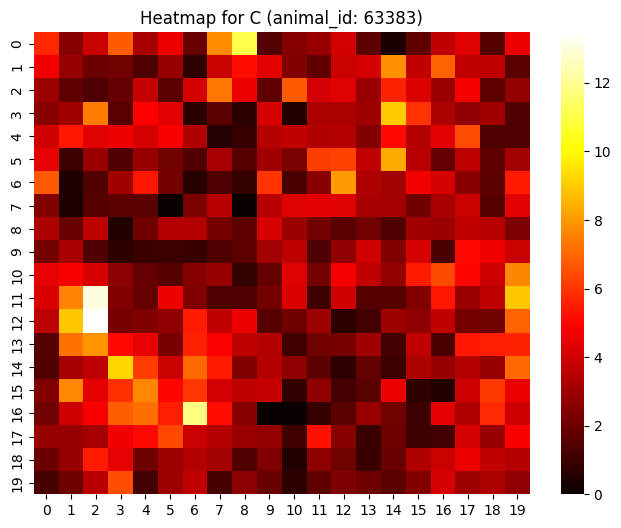

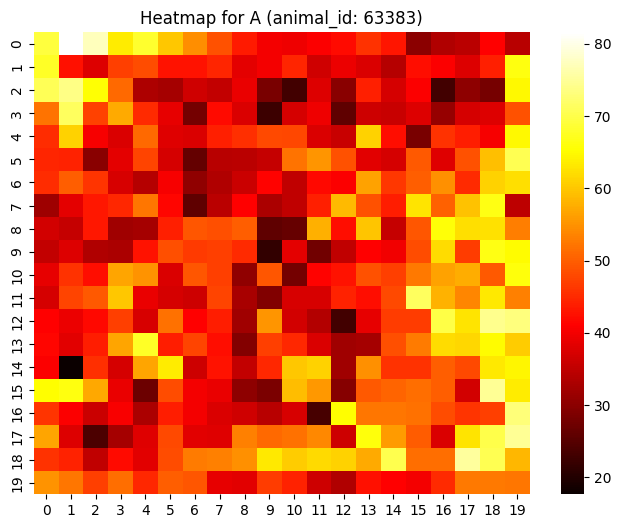

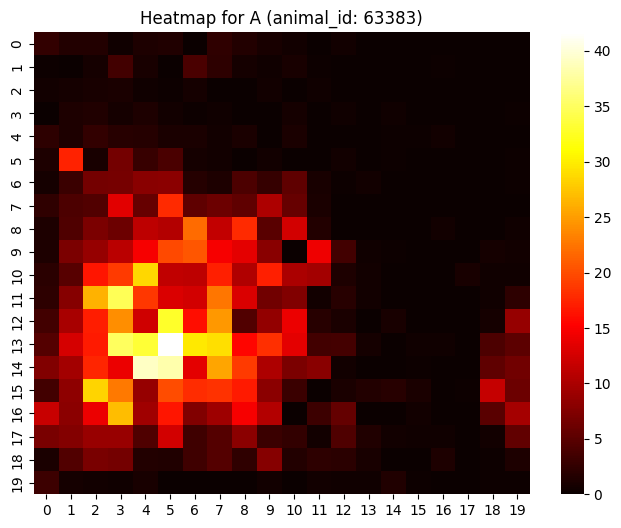

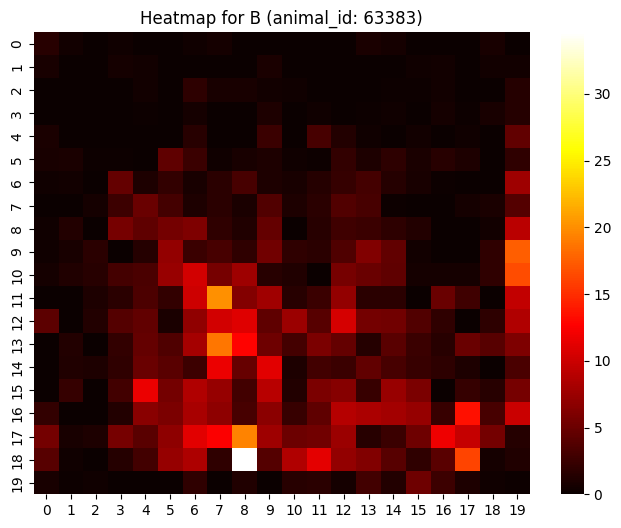

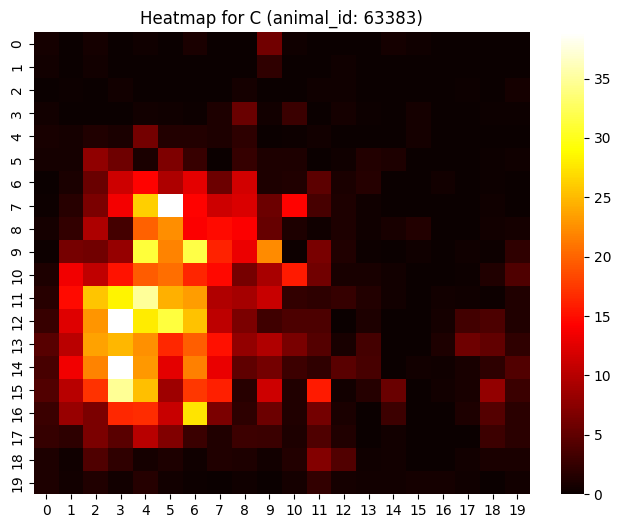

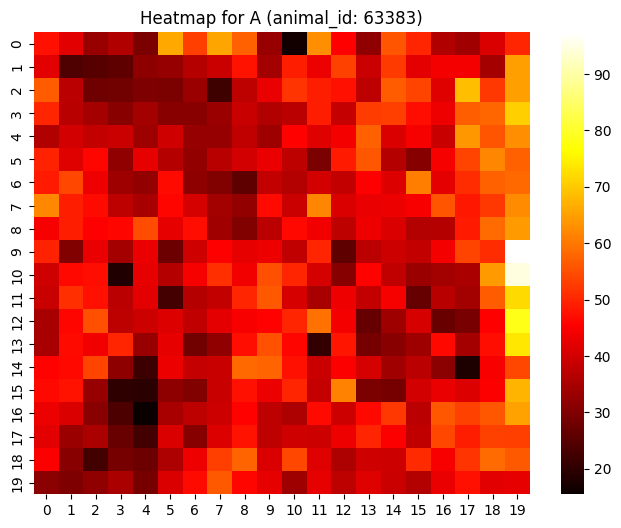

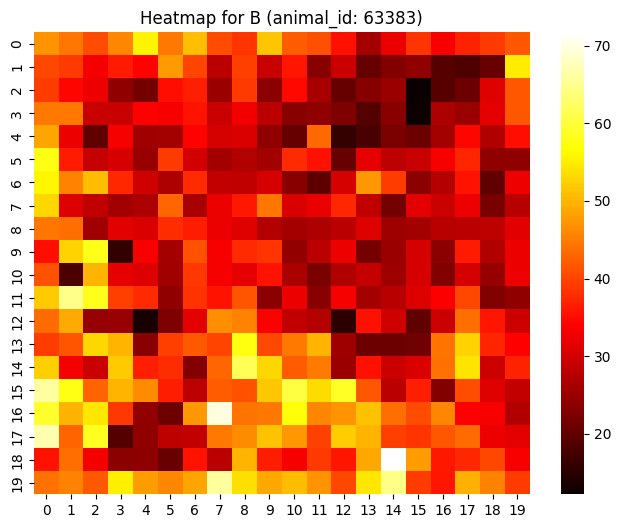

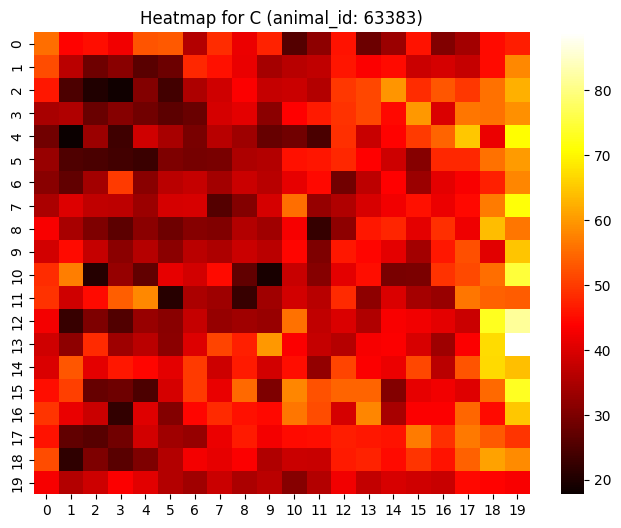

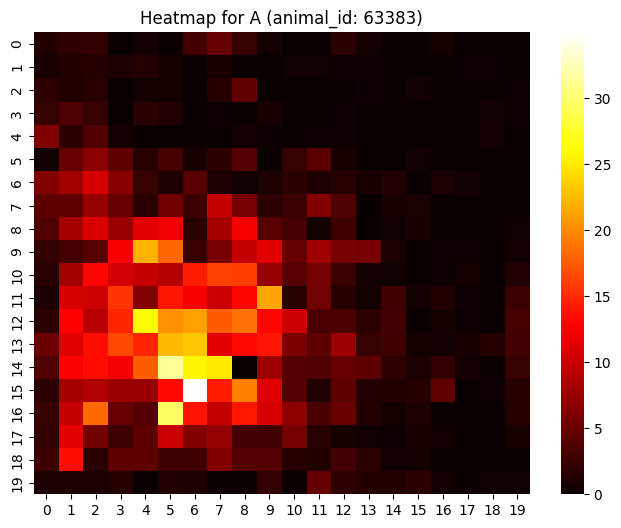

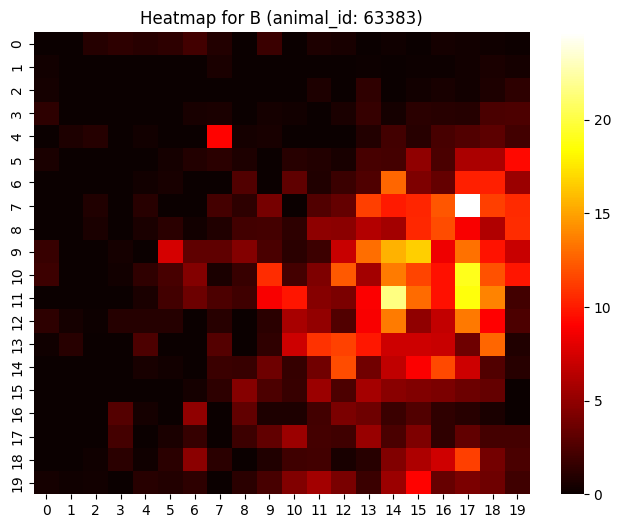

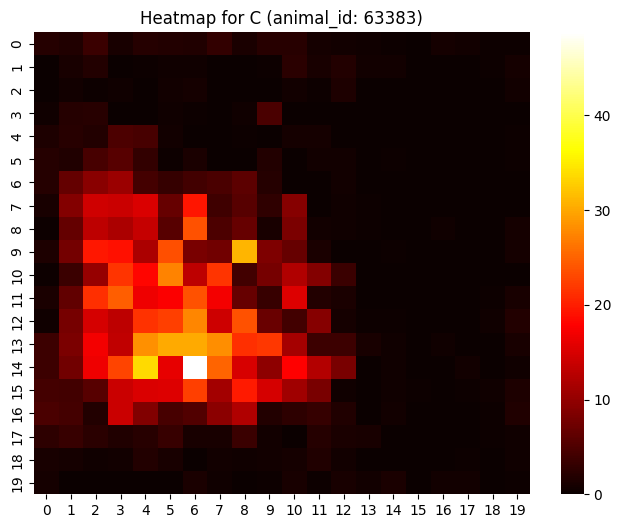

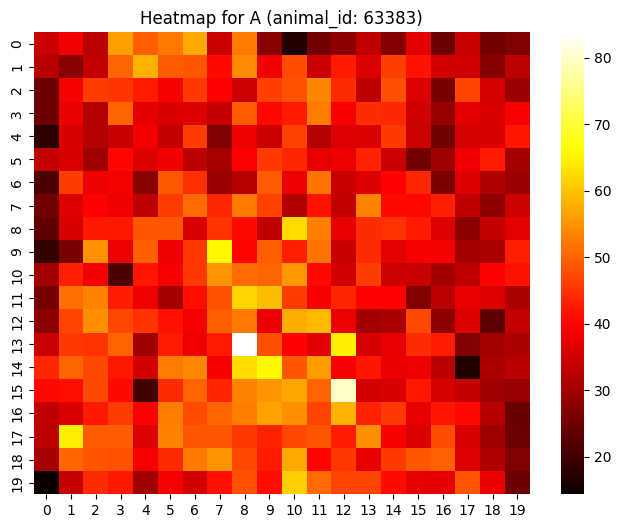

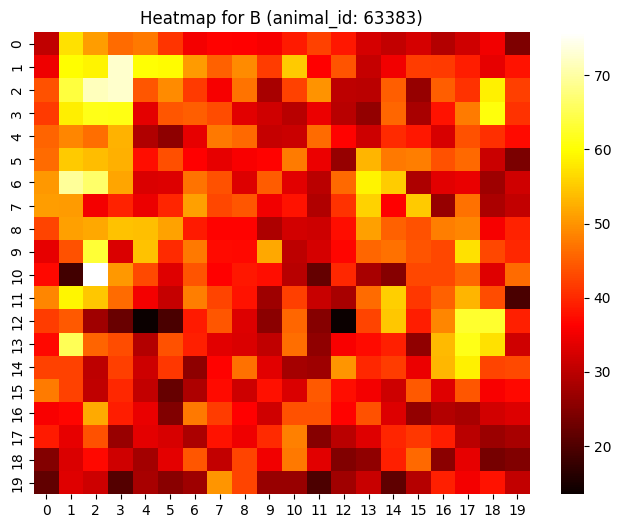

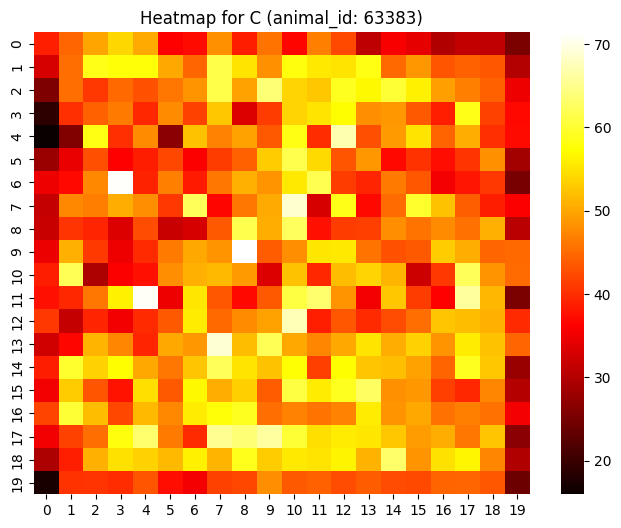

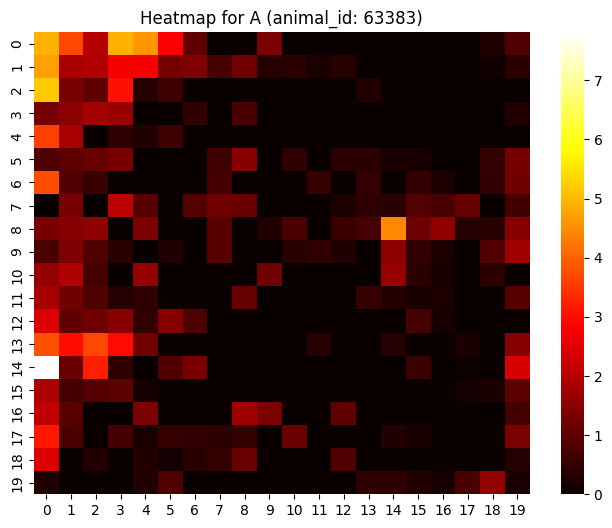

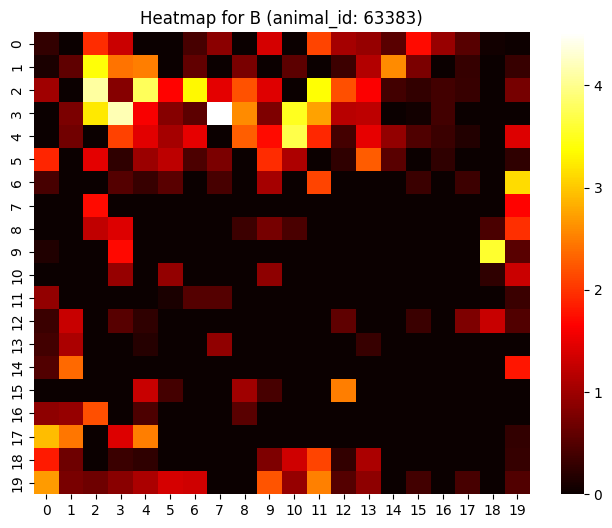

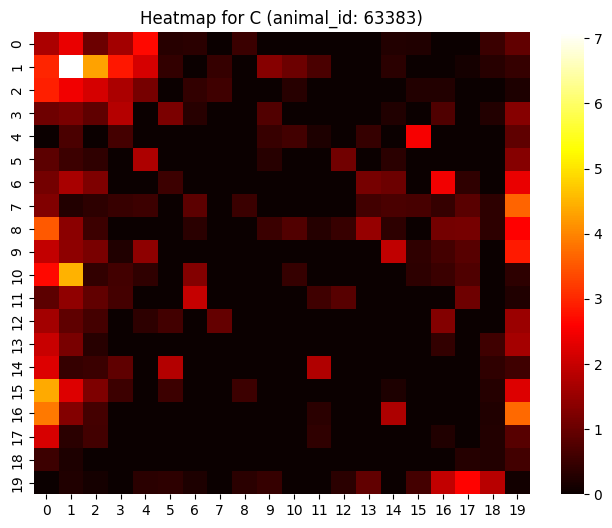

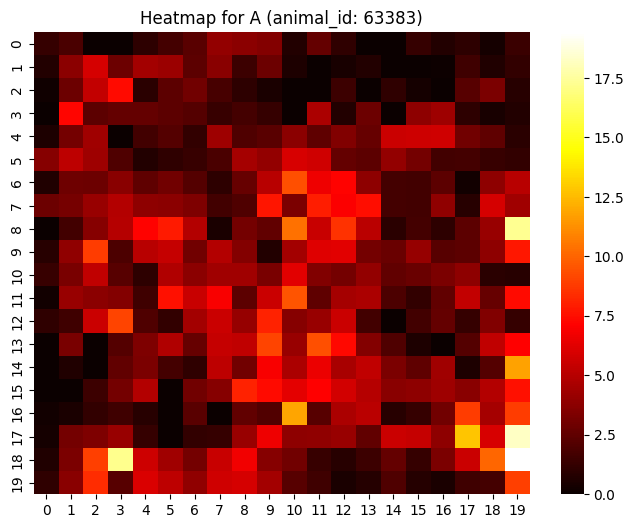

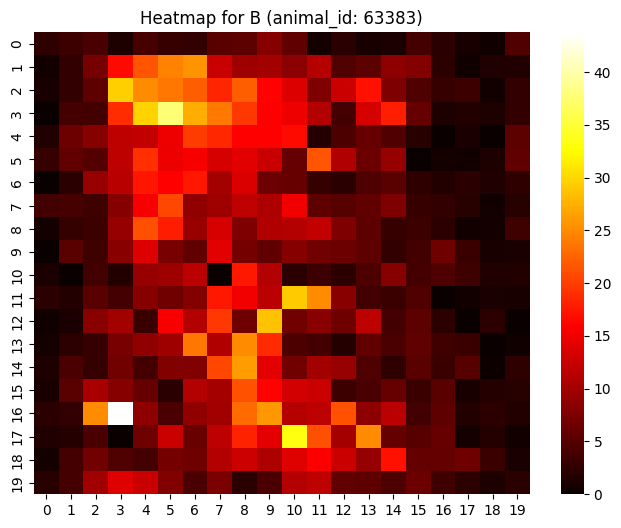

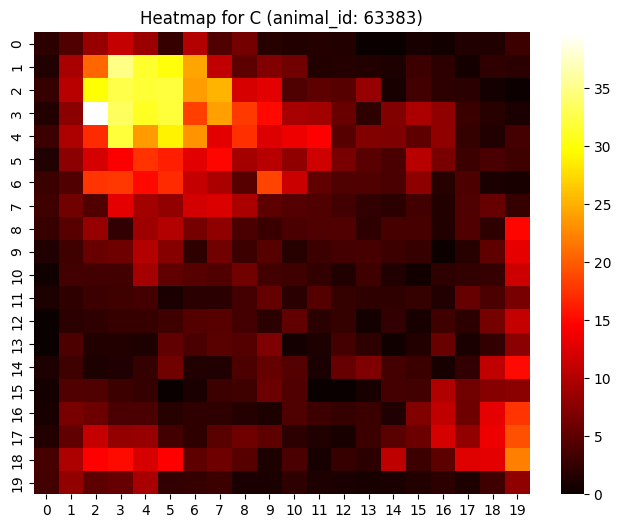

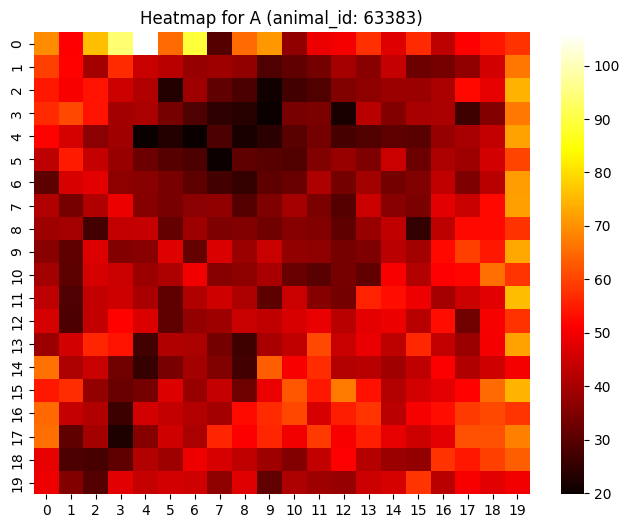

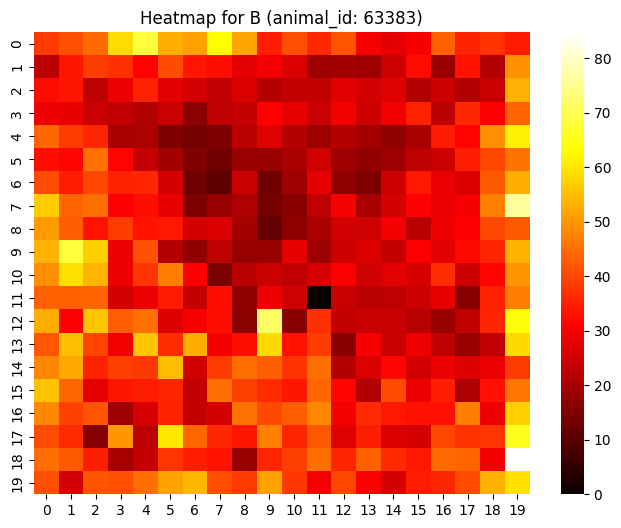

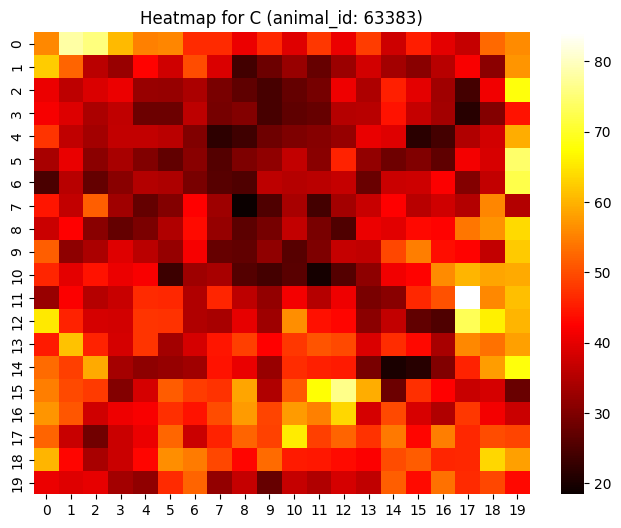

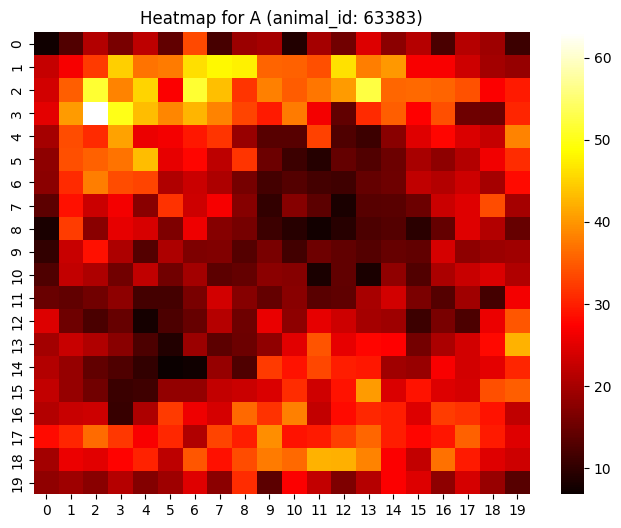

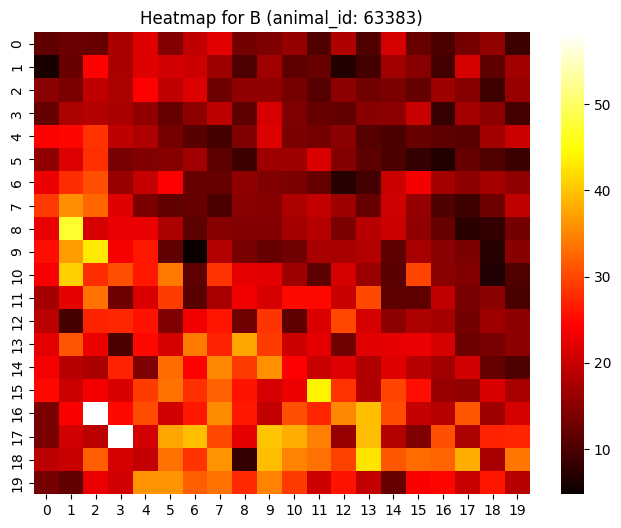

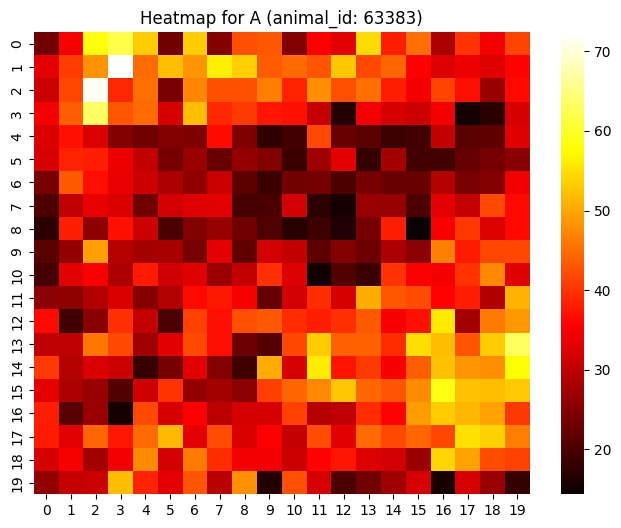

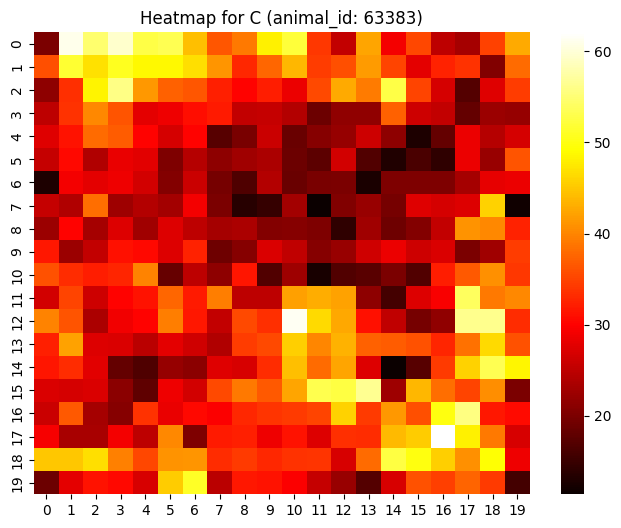

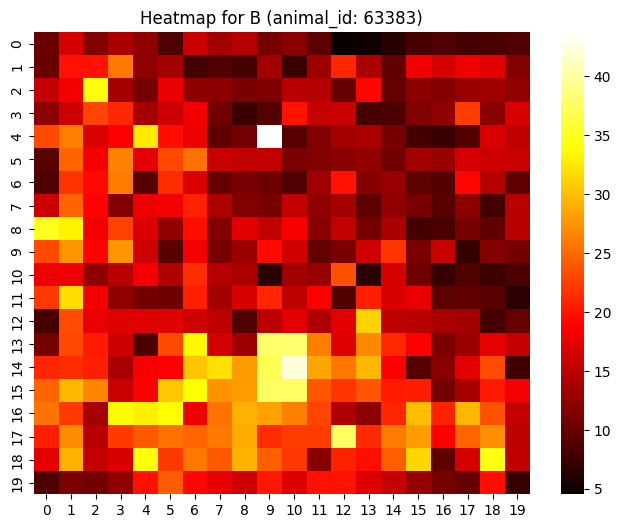

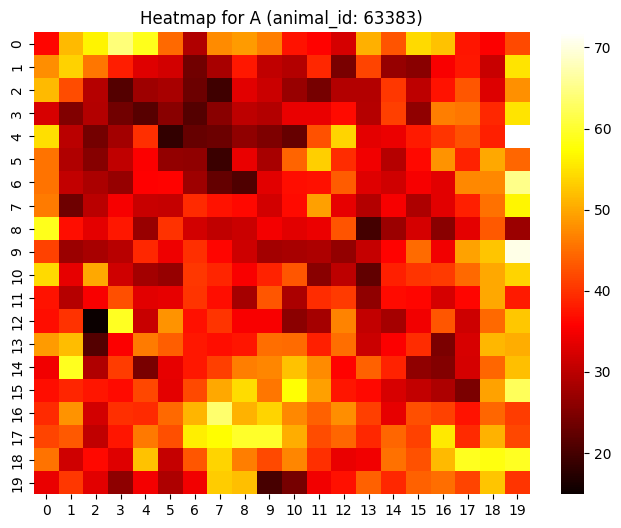

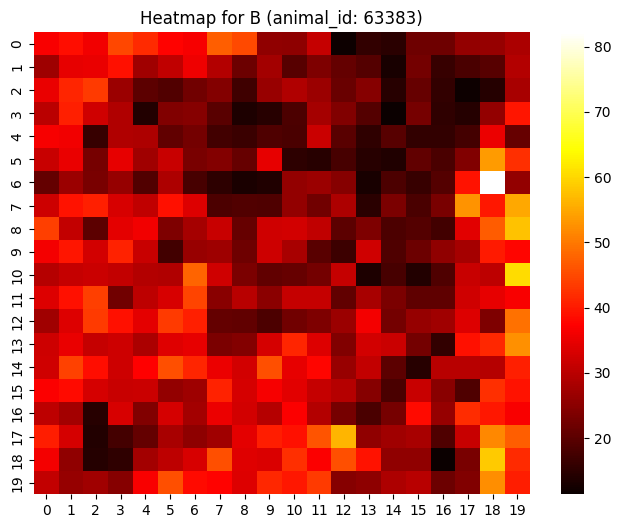

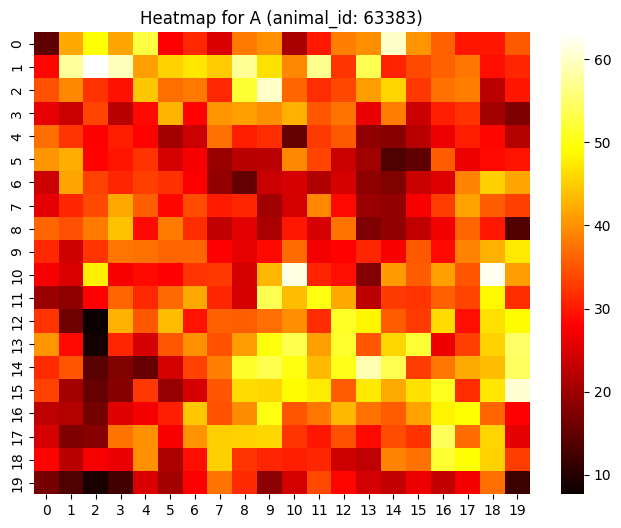

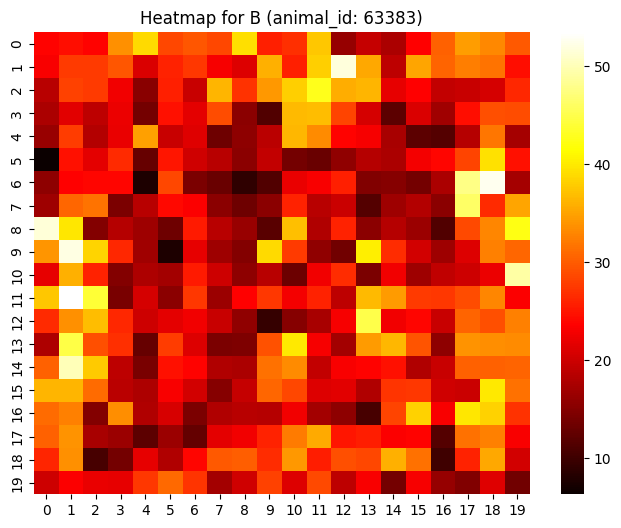

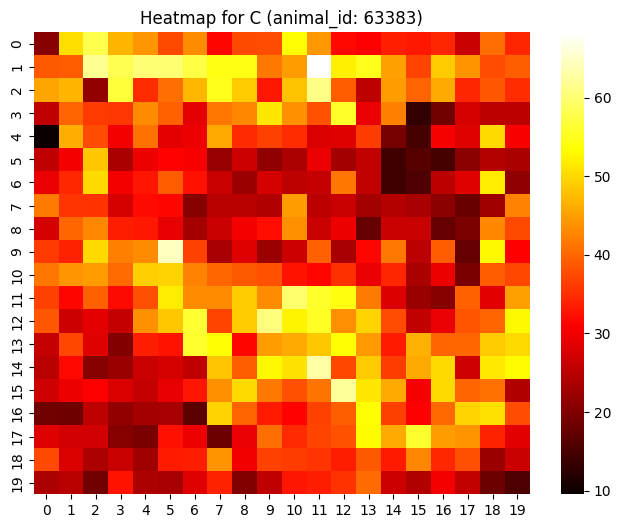

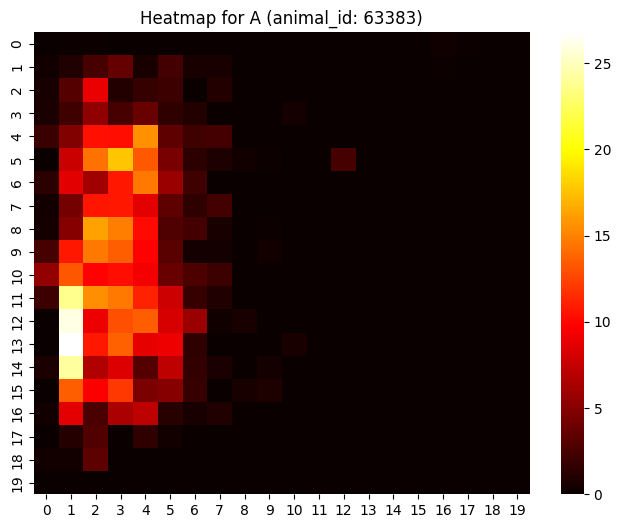

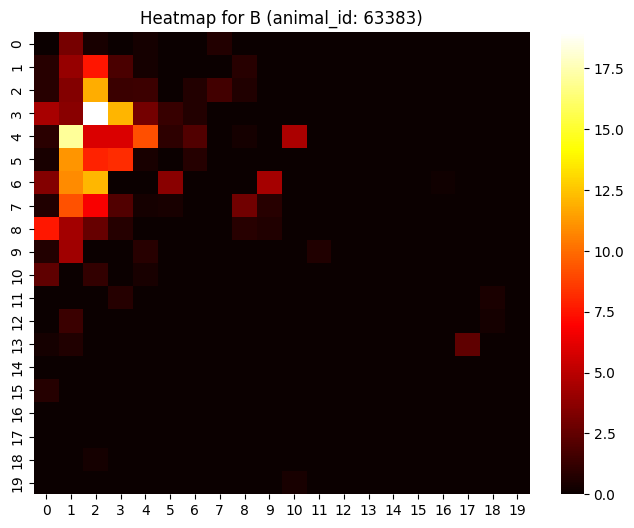

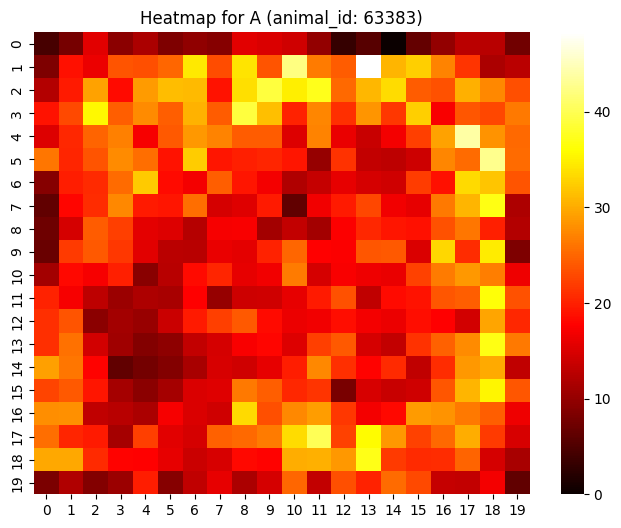

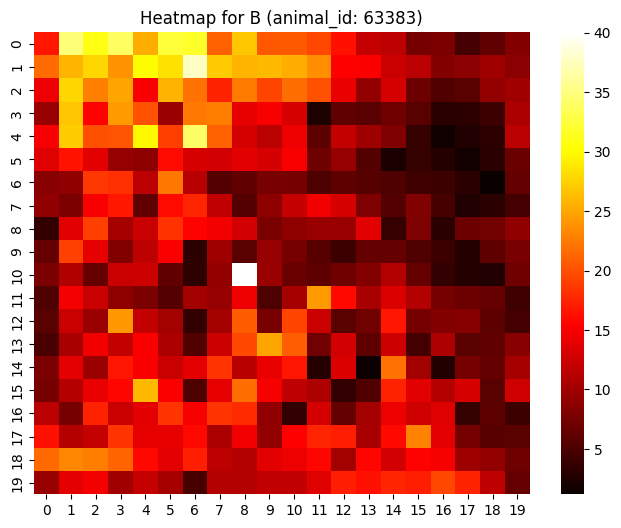

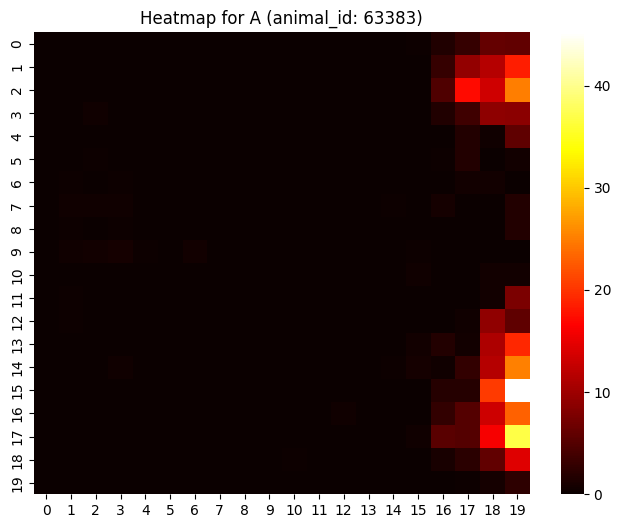

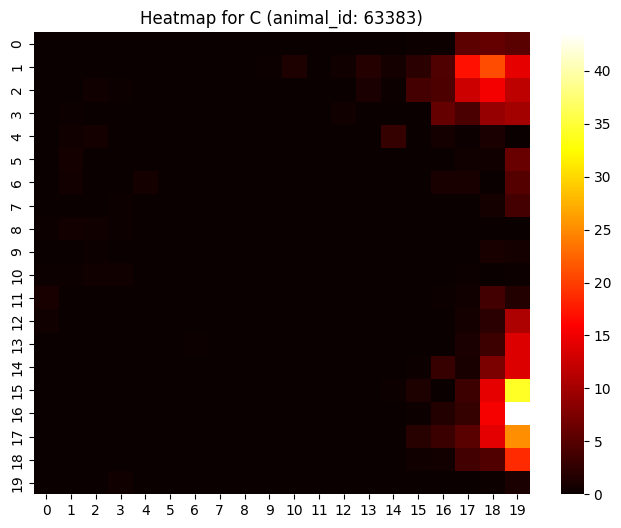

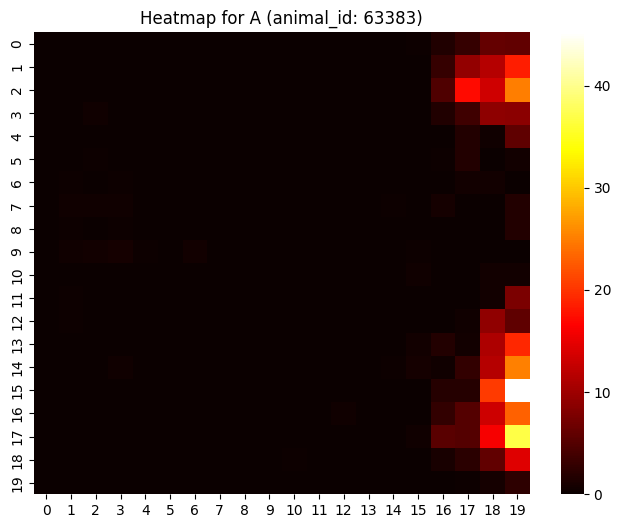

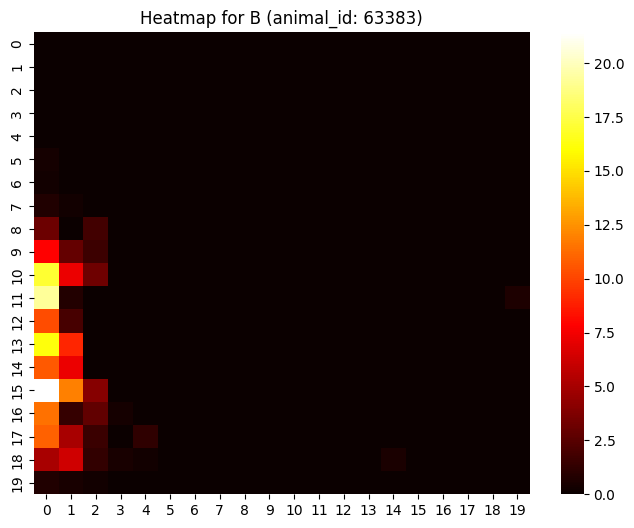

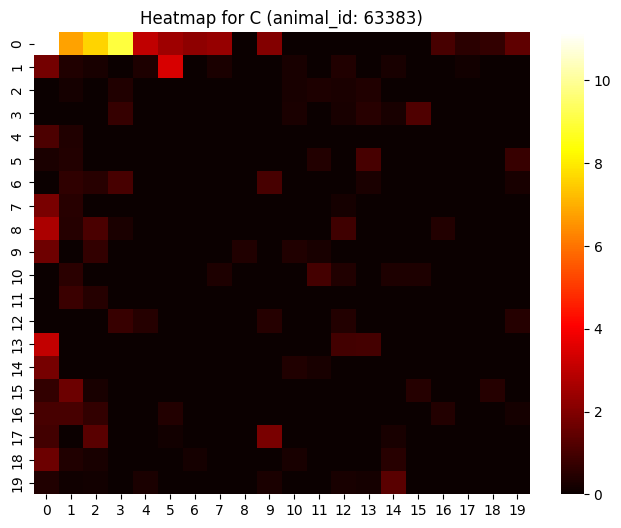

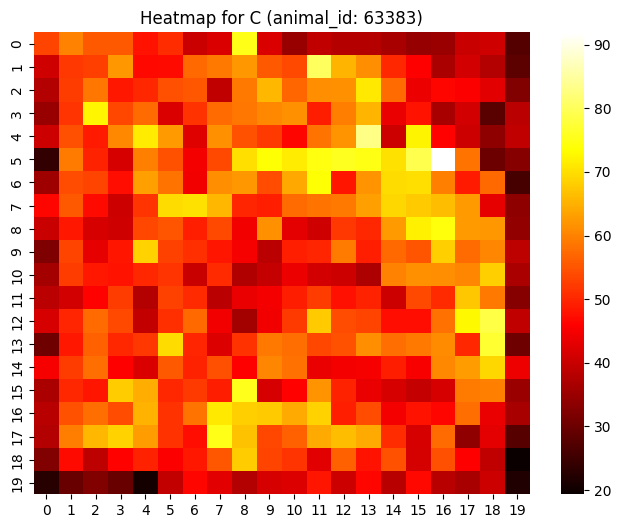

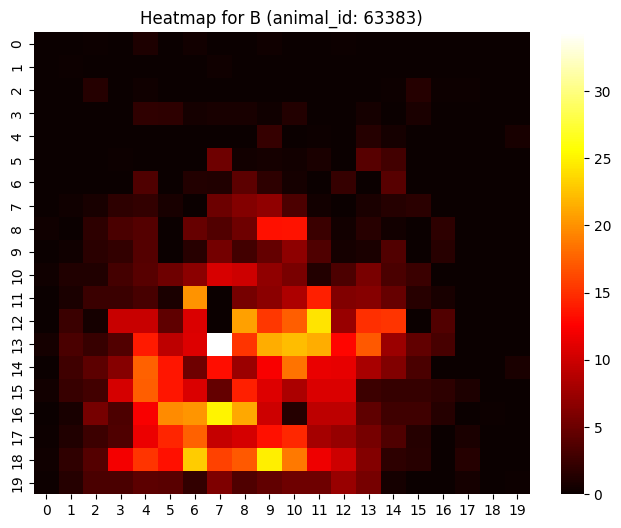

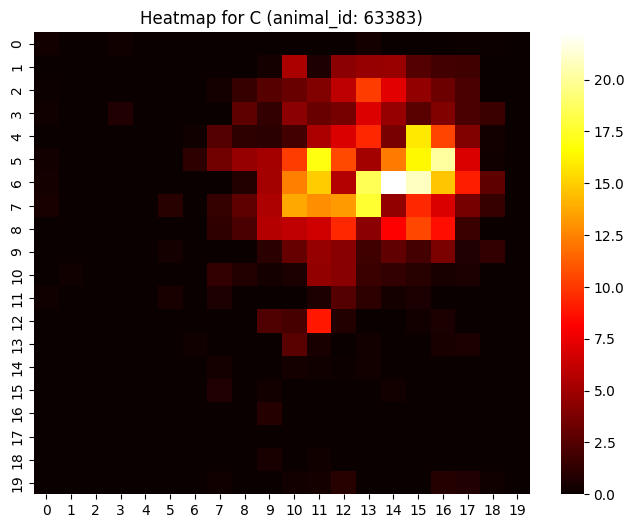

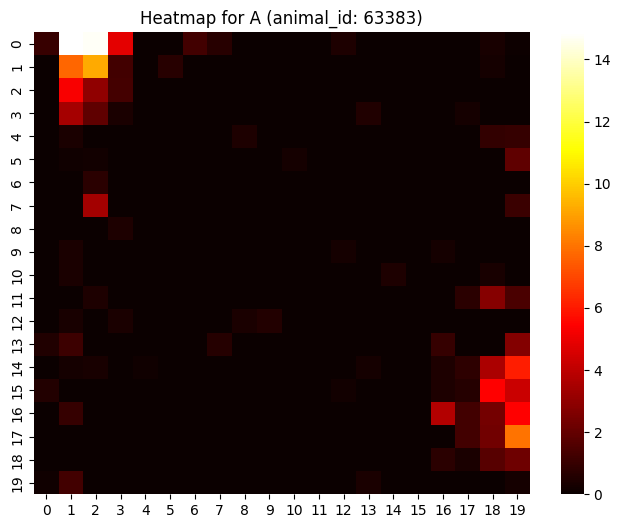

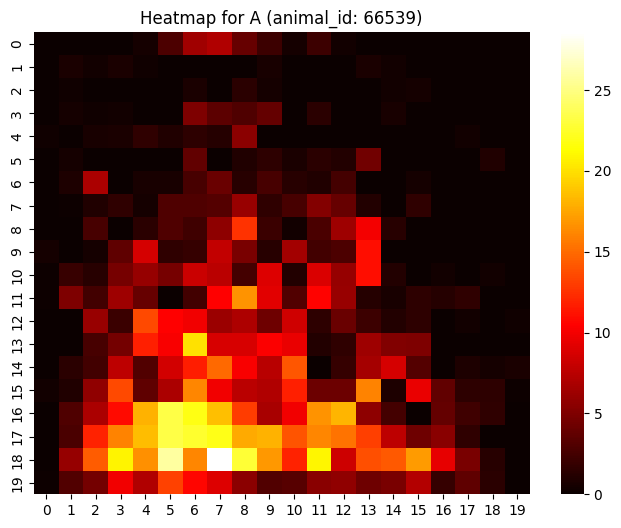

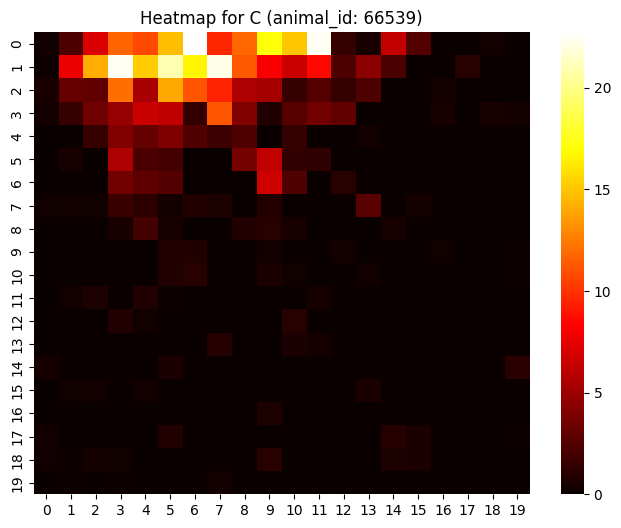

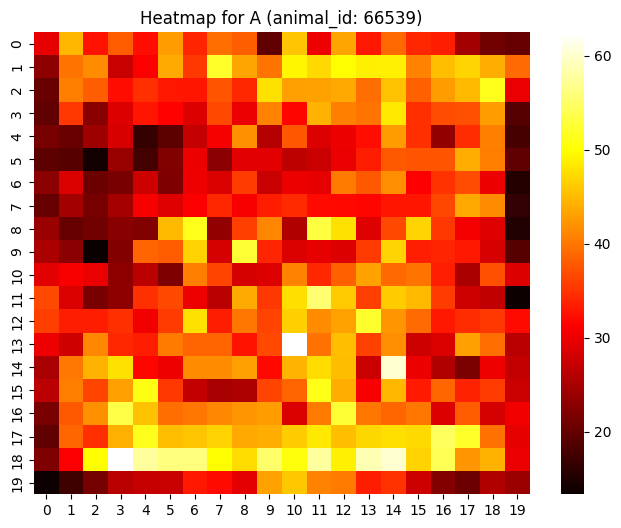

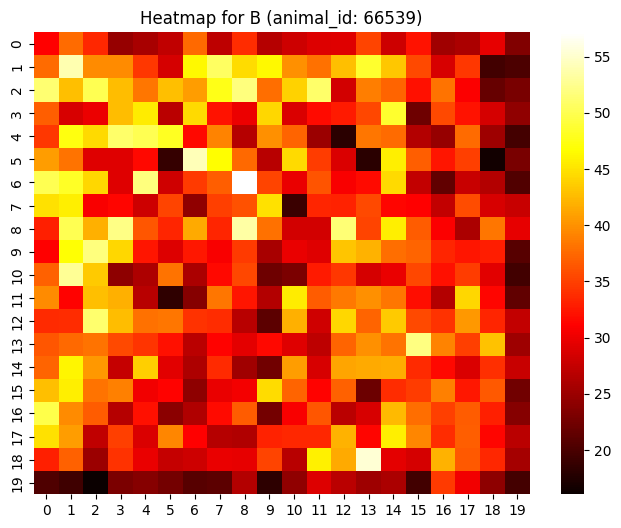

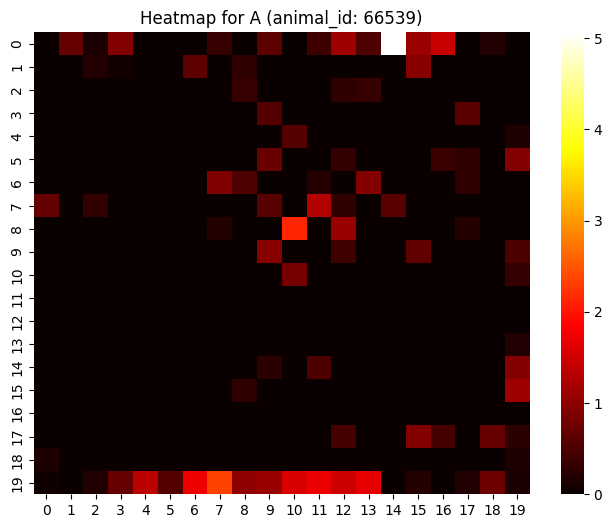

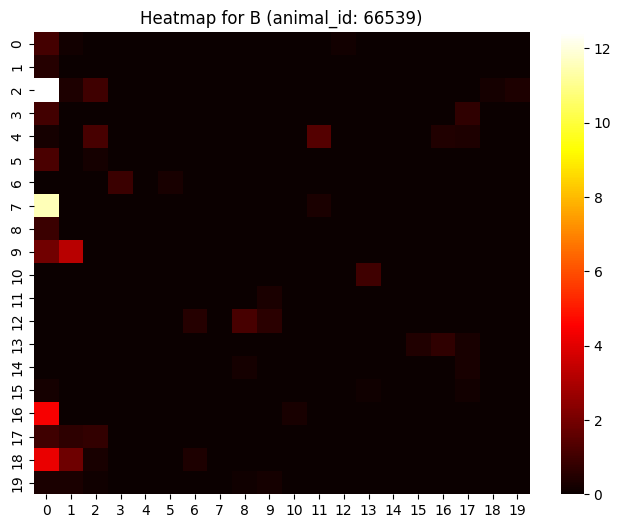

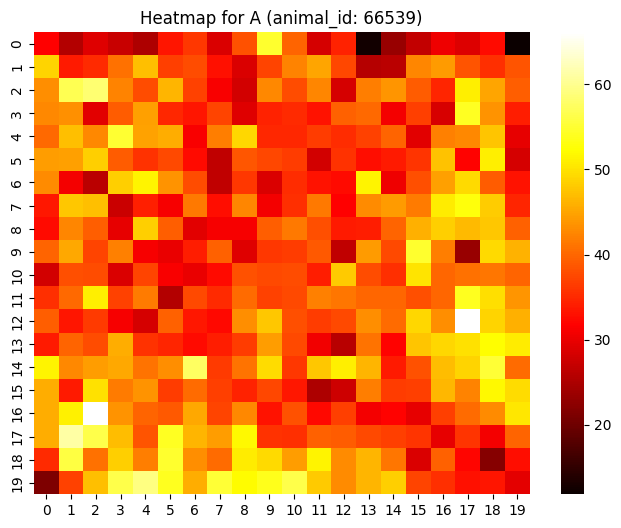

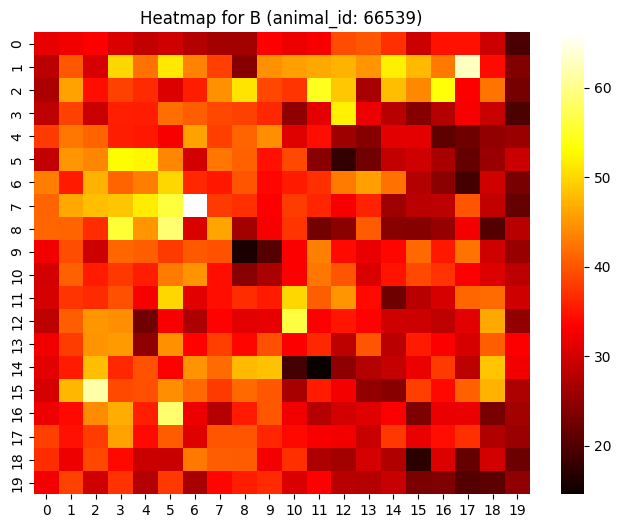

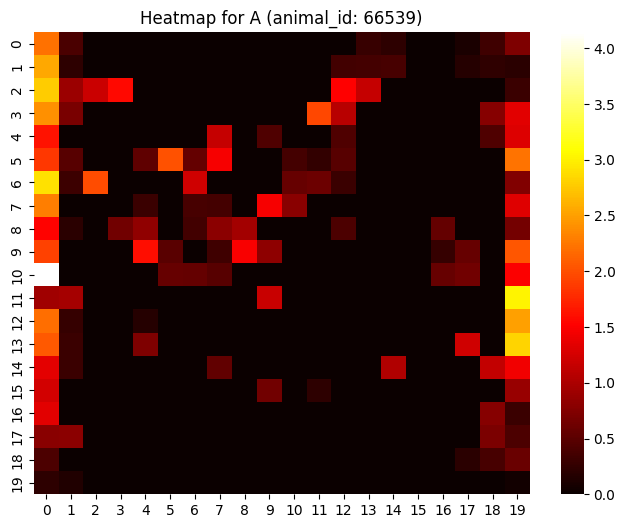

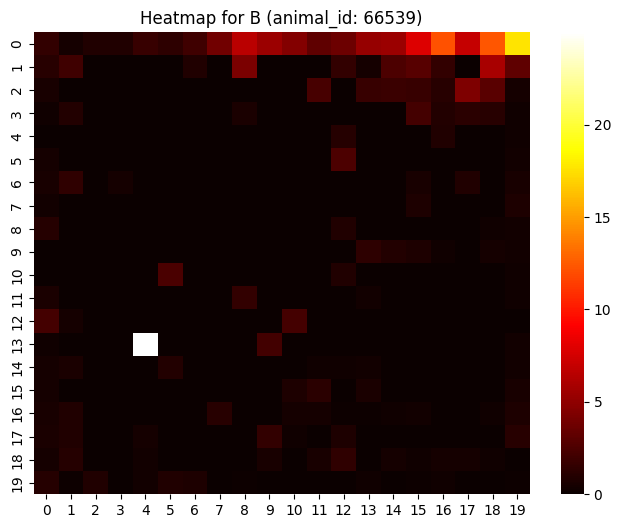

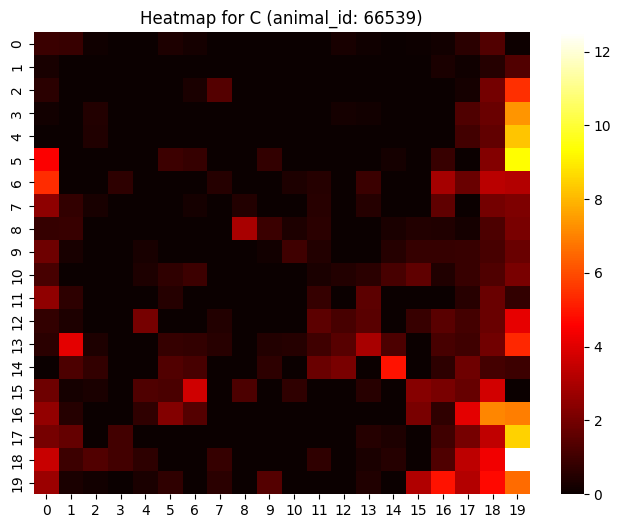

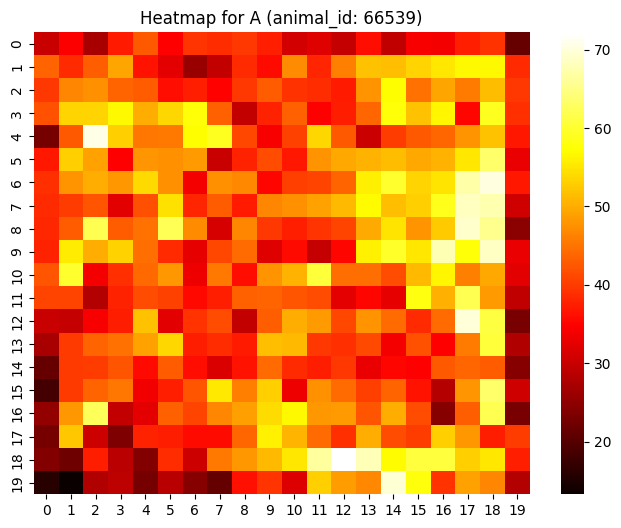

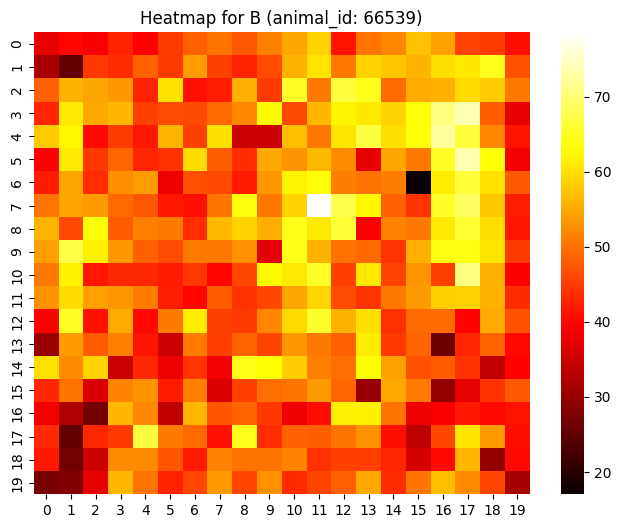

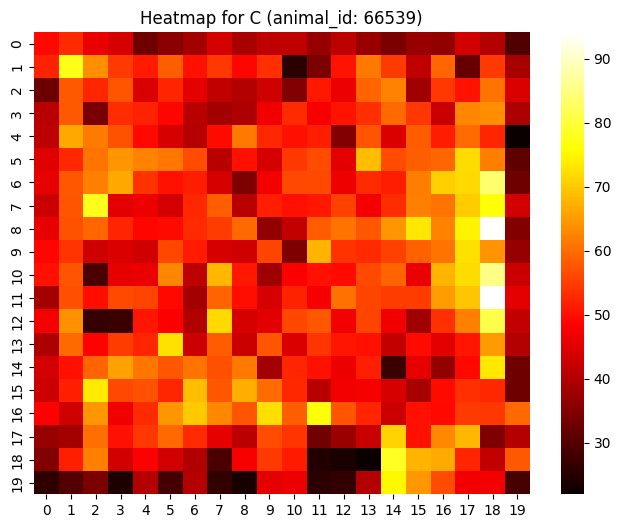

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df=control_df
columns_to_plot = ['A', 'B', 'C']

# Plotting heatmaps for each row and column
for index, row in df.iterrows():
    for column in columns_to_plot:
        array_data = row[column]
        plt.figure(figsize=(8, 6))
        sns.heatmap(array_data, cmap="hot")
        plt.title(f"Heatmap for {column} (animal_id: {row['animal_id']})")
        plt.show()

In [33]:
import os
os.chdir(r"Q:/sachuriga/Sachuriga_Python/quattrocolo-nwb4fp/src")

import pandas as pd
import sys
import nwb4fp.analyses.maps as mapp
from nwb4fp.analyses.examples.tracking_plot import plot_ratemap_ax,plot_path
from nwb4fp.analyses.fields import separate_fields_by_laplace, separate_fields_by_dilation,find_peaks,separate_fields_by_laplace_of_gaussian,calculate_field_centers,distance_to_edge_function, remove_fields_by_area, map_pass_to_unit_circle,which_field,compute_crossings
from elephant.statistics import time_histogram, instantaneous_rate
from nwb4fp.analyses import maps
from nwb4fp.analyses.data import pos2speed,speed_filtered_spikes,load_speed_fromNWB,load_units_fromNWB,get_filed_num,unit_location_ch,calculate_spatial_coherence,calculate_spatial_stability,coherence, find_run_indices
from scipy.ndimage import gaussian_filter
import ast
import pandas as pd
import pynapple as nap

df = pd.read_pickle(r"Q:\sachuriga\CR_CA1_paper\tables/functional_properties_with_python_measurements.pkl")
df = df[(df['h_0_place_cell']==1) & (df['Information_content_rate']>2) & (df['Information_content_rate'] < 2.5)] 


base_folder = r"S:\Sachuriga\nwb\test4neo/"

all_rates=[]
for i in range(8):
    file = df['session_id'].iloc[i]
    npdata = nap.load_file(fr"{base_folder}/{file}")
    pos_cord = load_speed_fromNWB(npdata['XY_mid_brain'])
    ## filter speed
    raw_pos,combined_array, mask,speeds,smoothed_speed,filtered_speed = pos2speed(pos_cord[:,0], # times
                                pos_cord[:,1], # x
                                pos_cord[:,2], # y
                                filter_speed=True, 
                                min_speed = 0.05)
    time_stemp = pos_cord[:,0]
    starts,stops = find_run_indices(smoothed_speed, threshold=0.05)
    run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')
    positions = nap.TsdFrame(t=pos_cord[:,0], d=pos_cord[:,1:3], columns=['X', 'Y'])
    speed_filtered = positions.restrict(run_ep).as_dataframe()

    temp = nap.Ts(df['spike_times'].iloc[i], time_units='s')
    spikes_time_speed_filtered = temp.restrict(run_ep)
    maps = mapp.SpatialMap(box_size=[1.0, 1.0], bin_size=0.05, smoothing=0.1)
    rate_map = maps.rate_map(speed_filtered['X'].values, speed_filtered['Y'].values, speed_filtered.index.values, spikes_time_speed_filtered.times())
    rate_map = rate_map / np.nanmean(rate_map) if np.nanmean(rate_map) != 0 else rate_map
    all_rates.append(rate_map)

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
C:\Users\sachur\AppData\Local\Temp\ipykernel_7440\3498689004.py:36: UserWarning: Some epochs have no duration
  run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
C:\Users\sachur\AppData\Local\Temp\ipykernel_7440\3498689004.py:36: UserWarning: Some epochs have no duration
  run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'core' version 

In [17]:
np.save(r"Q:\sachuriga\CR_CA1_paper\tables/population_vectors.npy",all_rates)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_population_vector_3d_heatmap(rate_maps, position,ax=None):
    """
    Plot stacked 2D heatmaps in 3D and a population vector at the specified position.
    
    Parameters:
    rate_maps : ndarray of shape (n_cells, height, width), e.g., (15, 20, 20)
    position : tuple (x, y), position to extract the population vector, e.g., (18, 18)
    """
    # Extract dimensions
    n_cells, height, width = rate_maps.shape
    x_pos, y_pos = position
    
    # Create a 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each rate map as a 2D heatmap at different Z levels
    for z in range(n_cells + 2):

        if z < n_cells:
            # Create a grid for the heatmap
            X, Y = np.meshgrid(np.arange(width), np.arange(height))
            # Normalize the rate map for colormap
            rate_map = rate_maps[z]
            # Create an RGBA image for the heatmap
            cmap = plt.cm.hot(rate_map / np.max(rate_map))
            # Plot the heatmap as a collection of colored squares
            for i in range(height):
                for j in range(width):
                    color = cmap[i, j]
                    ax.bar3d(j, i, z, 1, 1, 0, color=color, shade=False, alpha=0.6)

        if z == n_cells+1:
            X, Y = np.meshgrid(np.arange(width), np.arange(height))
            # Normalize the rate map for colormap
            rate_map = rate_maps[7]
            # Create an RGBA image for the heatmap
            cmap = plt.cm.hot(rate_map / np.max(rate_map))
            # Plot the heatmap as a collection of colored squares
            for i in range(height):
                for j in range(width):
                    color = cmap[i, j]
                    ax.bar3d(j, i, -3, 1, 1, 0, color=color, shade=False, alpha=0.6)

    # Add a vertical line at (x=15, y=15)
    ax.plot3D([x_pos, x_pos], [y_pos, y_pos],[-4, 8], color='blue', linewidth=5)
    
    # Add "PV" label at the top of the vertical line
    ax.text(x_pos, y_pos, 8, 'Population Vector', color='red', fontsize=14, ha='center', va='bottom')
    
    # Set labels and limits
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Cell Index')
    ax.set_zlim(0, n_cells-1)
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    
    # Customize z-axis ticks to show "1, 2, 3, ..., n"
    z_ticks = np.arange(n_cells)
    z_labels = [str(i+1) for i in range(n_cells)]
    z_labels[-1] = 'n'  # Replace the last label with 'n'
    ax.set_zticks(z_ticks)
    ax.set_zticklabels(z_labels)
    
    # Adjust the viewing angle for a more parallel perspective
    ax.view_init(elev=10, azim=45)  # Elevation = 10°, Azimuth = 45°
    plt.axis('off')
    # Save the plot
    plt.savefig('population_vector_3d_heatmap_plot.png')
    plt.show()

In [87]:
import numpy as np
# 示例数据：随机生成15个20x20的rate map
rate_maps = np.array(all_rates)
# 在(18, 18)位置绘制population vector
plot_population_vector_3d_heatmap(rate_maps, (18, 5))